In [1]:
from qiskit import *
from qiskit.providers.aer import AerSimulator
from qiskit.circuit import QuantumCircuit

# Import from Qiskit Aer noise module
from qiskit.providers.aer.noise import NoiseModel
from qiskit.providers.aer.noise import QuantumError, ReadoutError
from qiskit.providers.aer.noise import pauli_error
from qiskit.providers.aer.noise import depolarizing_error
from qiskit.providers.aer.noise import thermal_relaxation_error

from typing import Optional

import numpy as np
from random import *

In [2]:
def create_circuit(state: str, delay: int, basis: Optional[dict] = {0: 'z', 1: 'z'}) -> QuantumCircuit:
    """For E91, we take state to be '00', '01', '10', '11' """
    """basis will be of the form -> {0: 'x', 1: 'z'}, i.e., the qubit number followed
    by the basis of measurement"""
    
    qc = QuantumCircuit(2)
    
    # create the appropriate start state
    if state[0] == '1':
        qc.x(0)
    if state[1] == '1':
        qc.x(1)
    
    # create the superposition
    qc.h(0)
    qc.cx(0,1)
    
    # apply the delay
    qc.delay(delay, unit='ns')
    
    # apply the appropriate basis rotation
    for qubit, rot in basis.items():
        if qubit > 1:
            raise ValueError('Provided qubit number exceeds the number of qubits in the circuit')
        else:
            if rot == 'x' or rot == 'X':
                qc.h(qubit)
            elif rot == 'y' or rot == 'Y':
                qc.sdg(qubit)
                qc.h(qubit)
    
    # final measurement
    qc.measure_all()
    
    return qc

In [3]:
print(create_circuit('01',100).draw())

        ┌───┐     ┌────────────────┐ ░ ┌─┐   
   q_0: ┤ H ├──■──┤ Delay(100[ns]) ├─░─┤M├───
        ├───┤┌─┴─┐├────────────────┤ ░ └╥┘┌─┐
   q_1: ┤ X ├┤ X ├┤ Delay(100[ns]) ├─░──╫─┤M├
        └───┘└───┘└────────────────┘ ░  ║ └╥┘
meas: 2/════════════════════════════════╩══╩═
                                        0  1 


In [4]:
print(create_circuit('00',100,{0: 'z', 1: 'x'}).draw())

        ┌───┐     ┌────────────────┐      ░ ┌─┐   
   q_0: ┤ H ├──■──┤ Delay(100[ns]) ├──────░─┤M├───
        └───┘┌─┴─┐├────────────────┤┌───┐ ░ └╥┘┌─┐
   q_1: ─────┤ X ├┤ Delay(100[ns]) ├┤ H ├─░──╫─┤M├
             └───┘└────────────────┘└───┘ ░  ║ └╥┘
meas: 2/═════════════════════════════════════╩══╩═
                                             0  1 


In [5]:
def make_noise(noise_params: dict, delay: int, q1_gate_len: int,
               q2_gate_len: int, measure_len: int, apply_error: dict) -> NoiseModel:
    """noise params contains the values of T1, T2"""
    """1q_gate_len, 2q_gate_len, measure_len gives the duration of each"""
    """apply_error -> {"delay": bool, "measure": bool, "gate": bool} -> states which errors are on"""
    
    noise_model = NoiseModel()
    
    if apply_error["delay"]:
        thermal_delay = thermal_relaxation_error(noise_params["T1"],noise_params["T2"],delay)
        noise_model.add_all_qubit_quantum_error(thermal_delay,"delay")
        
    if apply_error["measure"]:
        thermal_measure = thermal_relaxation_error(noise_params["T1"],noise_params["T2"],measure_len)
        noise_model.add_all_qubit_quantum_error(thermal_measure,"measure")
    
    if apply_error["gate"]:
        thermal_gate_1q = thermal_relaxation_error(noise_params["T1"],noise_params["T2"],q1_gate_len)
        noise_model.add_all_qubit_quantum_error(thermal_gate_1q,["x","h","sdg","id"])
        
        q2_len = thermal_relaxation_error(noise_params["T1"],noise_params["T2"],q2_gate_len)
        thermal_gate_2q = q2_len.tensor(q2_len)
        noise_model.add_all_qubit_quantum_error(thermal_gate_2q,"cx")
    
    return noise_model

In [6]:
make_noise({"T1":188000, "T2":190000}, 100, 1000, 3000, 5000,
          {"delay":True, "measure": True, "gate": True})

<NoiseModel on ['measure', 'sdg', 'x', 'h', 'cx', 'id', 'delay']>

In [7]:
make_noise({"T1":188000, "T2":190000}, 100, 1000, 3000, 5000,
          {"delay":True, "measure": True, "gate": False})

<NoiseModel on ['measure', 'delay']>

In [8]:
noise_params = {"T1":93400, "T2":116160} # ibmq_lima
q1_gate_len = 35 # 3.5555555555555554e-08
q2_gate_len = 405.33 # ibmq_lima
measure_len = 5351.11 # ibmq_lima

In [9]:
def run(channel: str, delay: int, apply_error: dict, shots: Optional[int] = 1000) -> float:
    """Returns the probability of success for E91 protocol"""
    """Channel: 1 => |00>+|11>, 2 => |01>+|10>"""
    
    if channel == '1':
        state = '00'
    elif channel == '2':
        state = '01'
    
    qc = create_circuit(state,delay)
    backend = AerSimulator(noise_model=make_noise(noise_params,delay,q1_gate_len,q2_gate_len,measure_len,apply_error))
    counts = backend.run(qc,shots=shots).result().get_counts()
    
    success = 0
    
    if channel == '1':
        if '00' in counts.keys():
            success += counts['00']
        if '11' in counts.keys():
            success += counts['11']
    
    elif channel == '2':
        if '01' in counts.keys():
            success += counts['01']
        if '10' in counts.keys():
            success += counts['10']
            
    return float(success/shots)

In [10]:
run('1',1000,{"delay": True, "measure": False, "gate": False})

0.989

In [11]:
run('1',1000,{"delay": True, "measure": True, "gate": False})

0.946

In [12]:
run('1',1000,{"delay": True, "measure": True, "gate": True})

0.935

# Only Delay

In [10]:
import matplotlib.pyplot as plt

listofSuccess1=[]
for x in range(20): #loop for 20 times average
    delay = np.arange(0,1001000,1000)
    channel = '1'
    apply_error = {"delay":True, "measure": False, "gate": False}
    success = []

    # need to run in multiple loops to get a smoother curve
    for d in range(len(delay)):
        prob = run(channel,int(delay[d]),apply_error)
        success.append(prob)
    #print(success) Enable it to see the reading
    listofSuccess1.append(success)
    

In [11]:
from statistics import mean
a= listofSuccess1
print(*map(mean, zip(*a)))

1.0 0.9908 0.9793999999999999 0.96955 0.96 0.9512999999999999 0.9402 0.93035 0.9249 0.9197500000000001 0.90695 0.90515 0.89475 0.88615 0.8819 0.8734 0.86895 0.86205 0.85255 0.8527 0.84625 0.83755 0.83665 0.82775 0.8235 0.8206 0.81665 0.81065 0.8066500000000001 0.80105 0.8019000000000001 0.7978000000000001 0.7928000000000001 0.78825 0.7845500000000001 0.7855000000000001 0.7795500000000001 0.7806500000000001 0.7749 0.78045 0.76865 0.77275 0.76775 0.77035 0.77025 0.7634 0.7679 0.7601 0.7572 0.7567 0.7622 0.75765 0.75625 0.75905 0.75375 0.75305 0.751 0.75025 0.7487 0.7511 0.7474 0.7493 0.751 0.75045 0.74665 0.7558 0.75385 0.75605 0.74895 0.74615 0.7483 0.74675 0.7579 0.75085 0.75355 0.7558 0.7577 0.757 0.75495 0.756 0.7561 0.7606 0.75605 0.75975 0.7578 0.75675 0.75925 0.7661 0.7604 0.7625500000000001 0.76525 0.7615500000000001 0.77205 0.7677 0.7652 0.7665 0.77145 0.7719 0.77485 0.77975 0.7739 0.7777000000000001 0.7766000000000001 0.77615 0.78075 0.77825 0.7826500000000001 0.777700000000000

In [12]:
# 20 Times Average 
b=[1.0,0.9908,0.9793999999999999,0.96955,0.96,0.9512999999999999,0.9402,0.93035,0.9249,0.9197500000000001,0.90695,0.90515,0.89475,0.88615,0.8819,0.8734,0.86895,0.86205,0.85255,0.8527,0.84625,0.83755,0.83665,0.82775,0.8235,0.8206,0.81665,0.81065,0.8066500000000001,0.80105,0.8019000000000001,0.7978000000000001,0.7928000000000001,0.78825,0.7845500000000001,0.7855000000000001,0.7795500000000001,0.7806500000000001,0.7749,0.78045,0.76865,0.77275,0.76775,0.77035,0.77025,0.7634,0.7679,0.7601,0.7572,0.7567,0.7622,0.75765,0.75625,0.75905,0.75375,0.75305,0.751,0.75025,0.7487,0.7511,0.7474,0.7493,0.751,0.75045,0.74665,0.7558,0.75385,0.75605,0.74895,0.74615,0.7483,0.74675,0.7579,0.75085,0.75355,0.7558,0.7577,0.757,0.75495,0.756,0.7561,0.7606,0.75605,0.75975,0.7578,0.75675,0.75925,0.7661,0.7604,0.7625500000000001,0.76525,0.7615500000000001,0.77205,0.7677,0.7652,0.7665,0.77145,0.7719,0.77485,0.77975,0.7739,0.7777000000000001,0.7766000000000001,0.77615,0.78075,0.77825,0.7826500000000001,0.7777000000000001,0.78695,0.7847000000000001,0.7876000000000001,0.7866000000000001,0.7909,0.7908000000000001,0.791,0.7869,0.794,0.7969,0.79935,0.7981,0.7999,0.8041,0.805,0.8066,0.80785,0.8027,0.80765,0.807,0.80715,0.81165,0.8134,0.81515,0.8129,0.8165,0.8189,0.8207,0.8236,0.8214,0.8268,0.8252499999999999,0.8264,0.8231499999999999,0.82905,0.8287,0.82845,0.8332999999999999,0.83865,0.8346,0.83675,0.837,0.83795,0.844,0.8454499999999999,0.84365,0.8483499999999999,0.84255,0.84885,0.8512,0.85375,0.84905,0.85375,0.8534499999999999,0.86025,0.8539,0.8583,0.8596,0.86095,0.8603,0.8598,0.86625,0.86425,0.86815,0.86875,0.8727,0.8664,0.87145,0.8713,0.8684,0.87335,0.8749,0.87815,0.8776,0.87545,0.8807,0.8795,0.87935,0.8872,0.87855,0.8809,0.8829,0.88215,0.8906000000000001,0.8918,0.8866,0.8884,0.89325,0.8955500000000001,0.89425,0.8941,0.89445,0.8946500000000001,0.89985,0.8991,0.89975,0.89805,0.9043,0.90225,0.9011,0.9044,0.90505,0.9059,0.9057000000000001,0.9101,0.9116500000000001,0.9101,0.9105500000000001,0.90935,0.9143,0.915,0.91245,0.91325,0.9166500000000001,0.9131,0.9162,0.91705,0.91595,0.9175500000000001,0.9192,0.9239,0.92125,0.9208500000000001,0.9228000000000001,0.92295,0.92195,0.9257000000000001,0.9278500000000001,0.9251,0.9255500000000001,0.9274,0.9287,0.9287000000000001,0.9319000000000001,0.93235,0.9305,0.9296,0.93125,0.9337,0.93545,0.9343,0.9343,0.93415,0.9389,0.9376,0.9365,0.93885,0.9411499999999999,0.93555,0.9403,0.9387,0.9422499999999999,0.9406,0.94195,0.94145,0.9441499999999999,0.9430999999999999,0.9440999999999999,0.94375,0.945,0.9479,0.9476,0.94675,0.94645,0.94965,0.9452999999999999,0.9486,0.95055,0.9499,0.95075,0.95265,0.9522499999999999,0.9522499999999999,0.954,0.95495,0.9554499999999999,0.9526,0.9551,0.9566,0.9562499999999999,0.95815,0.9548,0.95565,0.9586,0.9569,0.9593999999999999,0.959,0.95915,0.9582499999999999,0.96055,0.95985,0.9607,0.95975,0.9592499999999999,0.96155,0.96115,0.96485,0.96115,0.96375,0.9662,0.9642,0.96455,0.96485,0.9646,0.9652,0.96515,0.96675,0.96555,0.96715,0.9664499999999999,0.9681,0.9677,0.9695,0.96905,0.9712999999999999,0.9703999999999999,0.9696,0.96885,0.9703499999999999,0.97275,0.9719,0.9726,0.9732999999999999,0.97355,0.9731,0.9712999999999999,0.97415,0.9716,0.97385,0.9736,0.9756,0.9743499999999999,0.9735,0.9733499999999999,0.976,0.97465,0.975,0.976,0.9764999999999999,0.9763999999999999,0.9783,0.9768,0.9783499999999999,0.97815,0.9773,0.97675,0.9772,0.9778,0.977,0.9787,0.97955,0.97985,0.97885,0.98025,0.979,0.97975,0.9803,0.9783999999999999,0.9796,0.9793499999999999,0.98175,0.981,0.982,0.9822,0.98165,0.98135,0.9821,0.9821,0.98175,0.98335,0.9823,0.98325,0.984,0.9844499999999999,0.9832,0.9823999999999999,0.98305,0.9833,0.98555,0.9838,0.98695,0.9847,0.9869,0.9844999999999999,0.98585,0.9857,0.9869,0.98495,0.98515,0.98705,0.9871,0.9869,0.9854499999999999,0.9868,0.9872,0.98665,0.9872,0.9873,0.9875,0.9876,0.9876,0.9872,0.98765,0.988,0.9884499999999999,0.9894499999999999,0.988,0.98825,0.9889,0.9892,0.98835,0.9903,0.989,0.98875,0.99005,0.98925,0.9906,0.9908,0.9895,0.9904,0.9889,0.99075,0.98905,0.9912,0.99095,0.9917,0.9901,0.99095,0.9904999999999999,0.99155,0.9903,0.99205,0.99035,0.98995,0.99055,0.9913,0.9916,0.992,0.9913,0.99065,0.9916,0.9924499999999999,0.9914,0.99165,0.99205,0.9931,0.99165,0.99315,0.99195,0.99175,0.9924999999999999,0.9934,0.9924,0.9924499999999999,0.9936,0.9923,0.9939,0.99285,0.9927,0.99265,0.99455,0.99325,0.9934499999999999,0.99325,0.99395,0.99395,0.9942,0.99285,0.9938,0.9936,0.99475,0.9946,0.9937,0.9932,0.9943,0.99465,0.9944,0.9937,0.9944,0.99485,0.9952,0.9944999999999999,0.99405,0.99365,0.99495,0.9954,0.9955,0.9952,0.9956,0.9951,0.99545,0.9952,0.99595,0.99575,0.996,0.99575,0.99525,0.99535,0.99595,0.99545,0.9951,0.99495,0.9952,0.9954,0.996,0.99545,0.997,0.9966,0.9954,0.9959,0.9967,0.99585,0.99755,0.9962,0.99625,0.9969,0.99615,0.9966,0.996,0.99655,0.996,0.99625,0.99605,0.99655,0.9968,0.9974,0.9967,0.9969,0.99655,0.9968,0.9968,0.9968,0.99635,0.9967,0.9973,0.9969,0.99715,0.99735,0.9971,0.9966,0.99755,0.9979,0.99715,0.9973,0.99795,0.99755,0.99785,0.9978,0.99835,0.9972,0.9978,0.99715,0.9975,0.997,0.9974,0.9975,0.9975,0.9978,0.9977,0.9979,0.9982,0.99795,0.9977,0.99775,0.9981,0.9975,0.99825,0.9977,0.99685,0.9977,0.998,0.9981,0.9977,0.99745,0.99795,0.99815,0.99845,0.99845,0.99805,0.9977,0.99795,0.99755,0.99775,0.9978,0.9984,0.9981,0.9989,0.99825,0.998,0.9986,0.99805,0.9983,0.9979,0.99865,0.99885,0.99815,0.9987,0.9983,0.9981,0.9984,0.9982,0.99835,0.99875,0.99835,0.99845,0.99845,0.9986,0.99835,0.9983,0.99905,0.9988,0.99875,0.9984999999999999,0.99855,0.99865,0.99875,0.9992,0.99845,0.99855,0.9987,0.9988,0.99835,0.9989,0.99895,0.9984,0.9988,0.9988,0.9991,0.99915,0.9989,0.999,0.9987,0.9994,0.9986,0.99915,0.99865,0.9986,0.9993,0.9992,0.99915,0.99915,0.99915,0.99915,0.99875,0.99915,0.9993,0.99885,0.9991,0.99945,0.99905,0.99925,0.99915,0.99945,0.9992,0.99915,0.9993,0.9992,0.99925,0.9992,0.99925,0.9992,0.99895,0.9993,0.9992,0.9993,0.99905,0.9994,0.9994,0.99915,0.999,0.9992,0.99915,0.9993,0.9994,0.999,0.99905,0.99915,0.9996,0.99905,0.99935,0.9993,0.9992,0.9994,0.9994,0.9994,0.9996,0.9996,0.9995,0.9995,0.99945,0.9995,0.9994,0.99945,0.99955,0.9993,0.99945,0.99965,0.99945,0.9999,0.9996,0.9997,0.9995,0.99945,0.9995,0.99945,0.99955,0.99955,0.99975,0.99945,0.99965,0.99925,0.9996,0.9994,0.9999,0.9995,0.99955,0.99965,0.9996,0.99955,0.99955,0.9996,0.9995,0.99955,0.9996,0.99975,0.9998,0.9995,0.99965,0.99965,0.99975,0.99955,0.9996,0.99965,0.9996,0.99955,0.9995,0.9995,0.9996,0.9995,0.9997,0.9995,0.99975,0.99975,0.9998,0.99965,0.9998,0.99985,0.9995,0.9998,0.9997,0.99975,0.9998,0.9997,0.99985,0.9997,0.9999,0.99985,0.9996,0.9996,0.9999,0.99945,0.99975,0.9999,0.99985,0.9998,0.99975,0.9996,0.9998,0.9999,0.99985,0.99985,0.99975,0.99955,0.99965,0.99975,0.9998,0.99975,0.9997,0.99975,0.9999,0.99955,0.99975,0.99965,0.99985,0.99985,0.9999,0.99975,0.99985,0.99995,0.9998,0.9998,0.99995,0.9999,0.99965,0.99975,0.99985,0.99975,0.99995,0.9999,0.99985,0.99975,0.9998,0.99975,0.99975,0.99975,0.99985,0.99965,0.99995,0.99995,0.9999,0.99995,0.9999,0.99995,0.9998,0.99975,0.99985,0.99985,0.9999,1.0,1.0,0.99975,0.99985,0.9998,0.99985,0.99985,0.9999,0.99985,0.9999,0.99995,0.9999,0.99995,0.9998,1.0,0.9999,0.9999,1.0,0.9999,0.99995,0.99995,0.99975,0.9998,0.9999,0.99995,0.99985,0.9999,0.9998,0.9998,0.99975,0.99985,0.99975,0.99995,0.99975,0.9998,0.99985,0.9998,0.9999,0.9999,0.9999,0.9999,1.0,0.99985,0.9999,0.99995,0.99995,0.99995,0.99995,0.99995,0.99985,0.9999,0.99995,0.99985,0.99995,0.99995,1.0,0.99995,0.99995,1.0,0.99985,0.9999,0.9998,0.99985,0.99985,0.9999,0.99995,0.99985,1.0,0.99995,0.99995,1.0,1.0,0.99985,0.99985,1.0,0.99995,1.0,0.99995,0.9999,0.9998,1.0,0.99995,0.99995,0.99995,0.99995,1.0,0.9999,0.99995,0.99995,1.0,0.9999,1.0,1.0,1.0,0.99995,0.9999,0.99995,0.9999,1.0,0.99995,0.99995,0.99995,0.99995,0.9999,0.99995,0.9998,1.0,0.99995,1.0,0.99995,0.99995,1.0,1.0,1.0,0.99995,1.0,0.99995,0.9999,0.99995,1.0,1.0,0.99985,0.99995,0.99995,0.9999,0.9999,1.0,0.99995,0.99995,0.99995,1.0,0.99995,0.99995,0.9999,0.9999,1.0,0.9999,0.99995,0.9999,1.0,1.0,0.99995,0.9999,0.99995,1.0,0.99995,1.0,1.0,1.0,1.0,0.99995,0.99995,0.99995,0.99995,0.9999,1.0,1.0,0.99995,0.99995,0.99995,1.0,1.0,1.0,0.99995,0.99995,0.99995,0.99995,1.0,0.9999,1.0,1.0,1.0,0.99995,1.0,1.0]

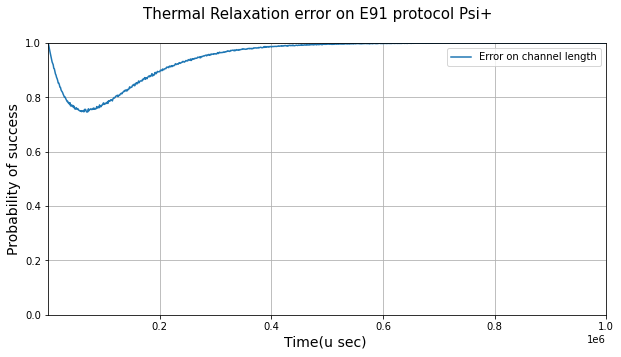

<Figure size 576x360 with 0 Axes>

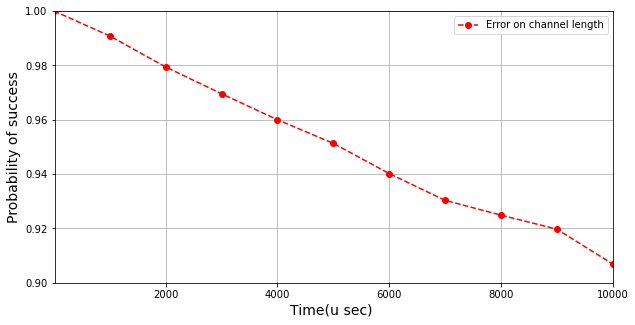

<Figure size 576x360 with 0 Axes>

In [20]:
%config InlineBackend.print_figure_kwargs={'facecolor' : "w"}
import matplotlib.pyplot as plt
from matplotlib.ticker import (AutoMinorLocator, MultipleLocator)
fig, ax = plt.subplots(figsize=(10, 5))
fig.suptitle('Thermal Relaxation error on E91 protocol Psi+',fontsize=15)
ax.set_xlim(10, 1000000)
ax.set_ylim(0,1)
plt.ylabel('Probability of success',fontsize=14)
plt.xlabel('Time(u sec) ',fontsize=14)
plt.grid()

fig = plt.figure(figsize=(8,5))
ax.plot(delay,b,label = "Error on channel length")
ax.legend()

#################################################################################

%config InlineBackend.print_figure_kwargs={'facecolor' : "w"}
import matplotlib.pyplot as plt
from matplotlib.ticker import (AutoMinorLocator, MultipleLocator)
fig, ax = plt.subplots(figsize=(10, 5))
#fig.suptitle('Thermal Relaxation error on E91 protocol',fontsize=15)
ax.set_xlim(10, 10000)
ax.set_ylim(0.9,1)
plt.ylabel('Probability of success',fontsize=14)
plt.xlabel('Time(u sec) ',fontsize=14)
plt.grid()

fig = plt.figure(figsize=(8,5))
ax.plot(delay,b,'ro--',label = "Error on channel length")
ax.legend()

In [14]:
listofSuccess2=[]
for z in range(20):
    delay = np.arange(0,1001000,1000)
    channel = '2'
    apply_error = {"delay":True, "measure": False, "gate": False}
    success = []

    # need to run in multiple loops to get a smoother curve
    for d in range(len(delay)):
        prob = run(channel,int(delay[d]),apply_error)
        success.append(prob)
    listofSuccess2.append(success)


In [15]:
from statistics import mean
a= listofSuccess2
print(*map(mean, zip(*a)))

1.0 0.98855 0.97895 0.9662999999999999 0.9592999999999999 0.94695 0.9362 0.92855 0.91805 0.9085500000000001 0.89825 0.89015 0.87925 0.87085 0.85935 0.8499 0.84315 0.83275 0.8185 0.81295 0.8066 0.7955 0.78885 0.78 0.7712 0.7689 0.75765 0.7504 0.73765 0.73305 0.7286 0.71765 0.70605 0.7051999999999999 0.6881 0.6778000000000001 0.68125 0.6712 0.668 0.65735 0.65075 0.6445500000000001 0.63925 0.62715 0.62605 0.6221 0.6154 0.60215 0.59285 0.59205 0.5892999999999999 0.5811 0.57185 0.5635 0.5534 0.54895 0.542 0.5382 0.5426 0.5305500000000001 0.5286500000000001 0.52 0.5181 0.5022 0.5034 0.4959 0.4904 0.49269999999999997 0.48925 0.47135 0.47415 0.47095 0.4656 0.46125 0.45455 0.43915 0.44775 0.43775 0.43755 0.4328 0.4221 0.42145 0.41635 0.4118 0.40105 0.4033 0.3986 0.3907 0.3955 0.3887 0.38265 0.3769 0.3693 0.37024999999999997 0.3635 0.35945 0.35995 0.3559 0.34855 0.3484 0.3427 0.34025 0.33225 0.3296 0.33425 0.32380000000000003 0.32285 0.31985 0.3194 0.3139 0.3079 0.3109 0.3 0.2996 0.2895 0.29095 

In [17]:
# 20 Times Average 
b2=[1.0,0.98855,0.97895,0.9662999999999999,0.9592999999999999,0.94695,0.9362,0.92855,0.91805,0.9085500000000001,0.89825,0.89015,0.87925,0.87085,0.85935,0.8499,0.84315,0.83275,0.8185,0.81295,0.8066,0.7955,0.78885,0.78,0.7712,0.7689,0.75765,0.7504,0.73765,0.73305,0.7286,0.71765,0.70605,0.7051999999999999,0.6881,0.6778000000000001,0.68125,0.6712,0.668,0.65735,0.65075,0.6445500000000001,0.63925,0.62715,0.62605,0.6221,0.6154,0.60215,0.59285,0.59205,0.5892999999999999,0.5811,0.57185,0.5635,0.5534,0.54895,0.542,0.5382,0.5426,0.5305500000000001,0.5286500000000001,0.52,0.5181,0.5022,0.5034,0.4959,0.4904,0.49269999999999997,0.48925,0.47135,0.47415,0.47095,0.4656,0.46125,0.45455,0.43915,0.44775,0.43775,0.43755,0.4328,0.4221,0.42145,0.41635,0.4118,0.40105,0.4033,0.3986,0.3907,0.3955,0.3887,0.38265,0.3769,0.3693,0.37024999999999997,0.3635,0.35945,0.35995,0.3559,0.34855,0.3484,0.3427,0.34025,0.33225,0.3296,0.33425,0.32380000000000003,0.32285,0.31985,0.3194,0.3139,0.3079,0.3109,0.3,0.2996,0.2895,0.29095,0.28875,0.2833,0.2838,0.2827,0.27125,0.27405,0.26475,0.2683,0.26375,0.2643,0.26165,0.25830000000000003,0.24945,0.2493,0.24735000000000001,0.24045,0.24675,0.2382,0.23554999999999998,0.2344,0.23035,0.2306,0.23065,0.2224,0.22315,0.2219,0.21705,0.2182,0.20935,0.21305,0.2108,0.20425,0.20495,0.20085,0.19690000000000002,0.19770000000000001,0.19685,0.193,0.19205,0.1877,0.1897,0.18455,0.18455,0.1857,0.18605,0.17845,0.1777,0.17149999999999999,0.16915,0.17535,0.16765,0.16555,0.15655,0.1656,0.1623,0.16065000000000002,0.1573,0.16105,0.15515,0.1539,0.1555,0.15065,0.14785,0.1413,0.14625,0.1457,0.13945,0.139,0.1369,0.13395,0.1349,0.1344,0.13515,0.12875,0.1308,0.1277,0.1252,0.1246,0.1257,0.1255,0.12415,0.12040000000000001,0.1168,0.12140000000000001,0.11410000000000001,0.1163,0.115,0.11535,0.10725,0.11315,0.11165,0.10975,0.10995,0.1072,0.106,0.1036,0.1048,0.1031,0.09935,0.1011,0.0961,0.09885,0.09705,0.095,0.09335,0.09965,0.09145,0.0902,0.08785,0.0911,0.0877,0.0908,0.08675,0.08524999999999999,0.0892,0.08155,0.08275,0.07735,0.08259999999999999,0.08405,0.0795,0.07855,0.07685,0.0789,0.08005,0.0761,0.0755,0.0746,0.07005,0.07255,0.0714,0.07015,0.0719,0.06705,0.06765,0.07055,0.07065,0.0686,0.06585,0.0631,0.06295,0.06315,0.06315,0.06465,0.06255,0.06175,0.0619,0.0618,0.05695,0.05975,0.057,0.0563,0.05585,0.05675,0.0569,0.05615,0.0534,0.0562,0.0554,0.04935,0.055,0.0513,0.05125,0.0516,0.05055,0.0506,0.04795,0.0474,0.04845,0.0489,0.04785,0.0468,0.0455,0.044700000000000004,0.0468,0.04415,0.0435,0.04455,0.0427,0.0403,0.04305,0.03915,0.0411,0.0395,0.04045,0.0408,0.0416,0.0398,0.0406,0.0376,0.0362,0.0377,0.03535,0.0369,0.03365,0.03685,0.0354,0.0326,0.037200000000000004,0.0343,0.03455,0.034,0.03425,0.0341,0.0325,0.03385,0.0329,0.03015,0.03085,0.0319,0.0312,0.02965,0.03025,0.0293,0.02905,0.0274,0.0297,0.027,0.0298,0.0311,0.02845,0.027,0.02775,0.0257,0.02715,0.0257,0.0258,0.02505,0.02555,0.02495,0.0249,0.02215,0.02395,0.02485,0.0237,0.0214,0.02195,0.02215,0.0217,0.02055,0.02205,0.02265,0.02255,0.0211,0.0223,0.02135,0.0224,0.02095,0.0211,0.02085,0.019450000000000002,0.0195,0.0197,0.0193,0.0185,0.01795,0.01835,0.01715,0.017750000000000002,0.0194,0.0176,0.01785,0.0186,0.01655,0.01685,0.01695,0.01715,0.01755,0.0151,0.0145,0.01635,0.01645,0.0167,0.01615,0.0146,0.01725,0.0141,0.01465,0.0148,0.015349999999999999,0.0149,0.0141,0.012499999999999999,0.01425,0.0137,0.0143,0.0139,0.0134,0.013,0.0114,0.01195,0.012799999999999999,0.0122,0.0124,0.0127,0.01215,0.01095,0.0103,0.01195,0.01135,0.0107,0.01105,0.012,0.01035,0.01055,0.011899999999999999,0.011349999999999999,0.01035,0.01045,0.0115,0.0091,0.009899999999999999,0.0095,0.01025,0.01035,0.00965,0.00985,0.01,0.00805,0.0093,0.01065,0.0101,0.0085,0.00905,0.00925,0.0087,0.008,0.007,0.00835,0.008,0.00825,0.00765,0.00835,0.0085,0.00815,0.0083,0.00765,0.00695,0.00705,0.0072,0.0075,0.0073,0.00815,0.0075,0.0079,0.0077,0.00715,0.00605,0.00745,0.007,0.00705,0.00655,0.00595,0.00605,0.0064,0.00685,0.006,0.00685,0.00535,0.0062,0.00705,0.00575,0.0051,0.0064,0.0067,0.0059,0.0056,0.005,0.00535,0.00515,0.0049,0.00575,0.00535,0.0054,0.00475,0.0055,0.00455,0.0043,0.0053,0.00545,0.0044,0.0049,0.0046500000000000005,0.00475,0.00475,0.0043,0.0046,0.0052,0.004,0.0043,0.00445,0.0041,0.00475,0.0046500000000000005,0.0042,0.00435,0.00395,0.00465,0.0043,0.00415,0.00385,0.00405,0.0041,0.00365,0.00405,0.00385,0.0035,0.0038,0.0032500000000000003,0.0038,0.0036,0.00315,0.0028,0.00355,0.00335,0.0039000000000000003,0.00295,0.00445,0.0038,0.00245,0.003,0.00315,0.0029000000000000002,0.0028,0.0027,0.003,0.00295,0.003,0.0035,0.00395,0.0026,0.0026,0.00315,0.00255,0.0027,0.0023,0.0033,0.002,0.00285,0.0033,0.0023,0.0025,0.0028,0.00255,0.0019,0.002,0.0026,0.0033,0.0021,0.0025,0.0022,0.0027,0.002,0.0024000000000000002,0.0024000000000000002,0.00215,0.0025,0.0024000000000000002,0.0014500000000000001,0.0021,0.0021,0.00185,0.0022500000000000003,0.00215,0.00245,0.0018,0.00235,0.0022,0.00175,0.0019,0.0022,0.00155,0.0014500000000000001,0.002,0.00185,0.00205,0.00215,0.002,0.0018,0.002,0.00175,0.0019,0.0014500000000000001,0.0013,0.0019,0.0018,0.0014500000000000001,0.0017000000000000001,0.0008500000000000001,0.001,0.00155,0.00155,0.00125,0.00135,0.00155,0.0017000000000000001,0.0017000000000000001,0.0015,0.00125,0.0017000000000000001,0.00095,0.0015,0.00125,0.001,0.0009,0.0012000000000000001,0.0008500000000000001,0.00115,0.0008,0.00105,0.0015,0.0007,0.0008,0.0009,0.00095,0.001,0.00135,0.00135,0.0014500000000000001,0.0008,0.00095,0.0011,0.0011,0.00105,0.0011,0.0014,0.0008500000000000001,0.001,0.0008,0.0011,0.0008,0.00105,0.0007,0.001,0.0009,0.0007,0.0007,0.00065,0.00095,0.0007,0.00105,0.00075,0.00105,0.0009,0.0008500000000000001,0.0006000000000000001,0.0009,0.001,0.0008500000000000001,0.00065,0.00115,0.00075,0.0008,0.00075,0.0008,0.0008500000000000001,0.0008,0.0008,0.00105,0.0006000000000000001,0.0008,0.0008500000000000001,0.0008500000000000001,0.00045,0.00095,0.001,0.00105,0.0008,0.0007,0.0007,0.0005,0.0005,0.0008,0.0006000000000000001,0.00045,0.00075,0.00030000000000000003,0.00055,0.00025,0.00030000000000000003,0.0007,0.00055,0.0005,0.00065,0.00045,0.00035,0.00045,0.00075,0.0004,0.00025,0.0006000000000000001,0.00065,0.00035,0.00075,0.0005,0.00055,0.00055,0.00065,0.00045,0.00045,0.00055,0.0004,0.00055,0.00030000000000000003,0.00045,0.0007,0.00055,0.00025,0.0006000000000000001,0.0004,0.0005,0.00030000000000000003,0.0005,0.0004,0.00035,0.0004,0.0004,0.0006000000000000001,0.0007,0.0002,0.00030000000000000003,0.0004,0.00030000000000000003,0.00035,0.00030000000000000003,0.00055,0.00015000000000000001,0.00025,0.00025,0.00035,0.00035,0.0006000000000000001,0.0005,0.00030000000000000003,0.00030000000000000003,0.00045,0.0001,0.00035,0.00015000000000000001,0.0004,0.00035,0.0004,0.00035,0.00015000000000000001,0.0002,0.0002,0.00030000000000000003,0.00030000000000000003,0.00030000000000000003,0.00015000000000000001,0.00025,0.0002,0.00030000000000000003,0.00015000000000000001,0.00030000000000000003,0.00030000000000000003,0.00035,0.00035,0.00015000000000000001,0.00025,0.00025,0.00015000000000000001,0.0002,0.0004,0.00015000000000000001,0.00015000000000000001,0.00025,0.0002,0.00025,0.00015000000000000001,0.00015000000000000001,0.00030000000000000003,0.00045,5e-05,5e-05,0.0001,5e-05,0.00030000000000000003,0.00025,0.0001,0.0002,0.0001,0.00030000000000000003,0.0,0.00035,0.00025,0.00030000000000000003,0.0001,0.00030000000000000003,0.0002,5e-05,5e-05,0.00015000000000000001,0.0002,0.0001,0.0002,0.00030000000000000003,0.00015000000000000001,0.0001,5e-05,0.0,0.0001,0.0002,0.0002,0.00015000000000000001,0.0001,5e-05,0.0001,0.0001,0.00025,0.0002,0.00025,0.0001,0.00025,0.00015000000000000001,0.0,0.0,5e-05,5e-05,0.00015000000000000001,0.0002,0.00025,0.00015000000000000001,5e-05,0.00015000000000000001,0.0001,0.00015000000000000001,0.00025,0.00015000000000000001,5e-05,5e-05,0.00015000000000000001,5e-05,0.00015000000000000001,0.00015000000000000001,0.0001,0.00015000000000000001,0.0001,0.00015000000000000001,0.00015000000000000001,0.0,0.00015000000000000001,0.00015000000000000001,0.0,0.00015000000000000001,0.0001,0.0001,0.0001,0.00015000000000000001,0.0001,0.0002,5e-05,0.0001,0.0001,0.0001,0.0,5e-05,0.00015000000000000001,0.0001,5e-05,5e-05,5e-05,5e-05,0.0,5e-05,0.00015000000000000001,0.00015000000000000001,0.0001,0.0001,5e-05,0.0001,0.0,0.0001,0.0001,0.0,0.0001,5e-05,0.00015000000000000001,5e-05,0.0,0.0,0.0001,0.0001,5e-05,0.0,0.0,0.0,0.0,5e-05,0.0001,5e-05,5e-05,0.0001,0.0001,0.0001,0.0,0.0,5e-05,0.00015000000000000001,0.00015000000000000001,0.0001,5e-05,5e-05,0.0,0.00015000000000000001,0.0001,0.0,0.0001,0.0001,0.0,5e-05,0.0001,0.0001,0.0,0.0,0.0,0.0,5e-05,0.0,0.0,5e-05,0.0,5e-05,5e-05,0.0002,0.0001,0.0001,0.0,0.0,0.0,0.0001,5e-05,5e-05,5e-05,0.0,0.0,5e-05,5e-05,0.0001,5e-05,0.00015000000000000001,5e-05,0.0,0.0,0.0,0.0,0.0,0.0,5e-05,0.0,5e-05,0.0,0.0,0.0,0.0,0.0,0.0001,0.0,0.0001,0.0,0.0,0.0,0.0001,0.0,0.0,0.0,5e-05,5e-05,5e-05,0.0,0.0,0.0,0.0,5e-05,0.0001,0.0,5e-05,5e-05,0.0,0.0,0.0,0.0,0.0,5e-05,0.0]


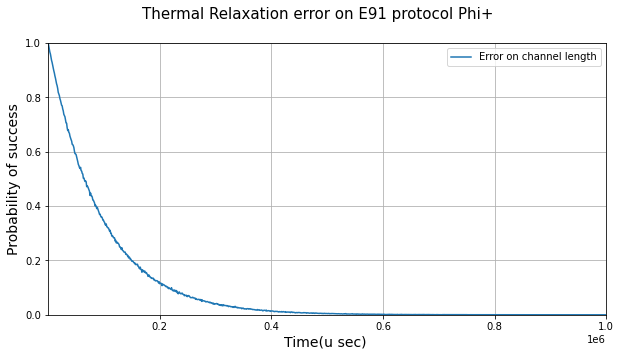

<Figure size 576x360 with 0 Axes>

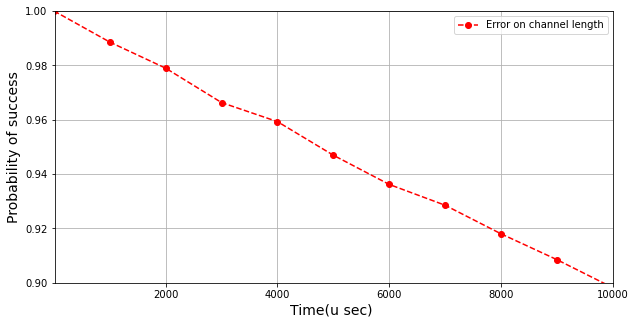

<Figure size 576x360 with 0 Axes>

In [19]:
%config InlineBackend.print_figure_kwargs={'facecolor' : "w"}
import matplotlib.pyplot as plt
from matplotlib.ticker import (AutoMinorLocator, MultipleLocator)
fig, ax = plt.subplots(figsize=(10, 5))
fig.suptitle('Thermal Relaxation error on E91 protocol Phi+',fontsize=15)
ax.set_xlim(10, 1000000)
ax.set_ylim(0,1)
plt.ylabel('Probability of success',fontsize=14)
plt.xlabel('Time(u sec) ',fontsize=14)
plt.grid()

fig = plt.figure(figsize=(8,5))
ax.plot(delay,b2,label = "Error on channel length")
ax.legend()

#################################################################################

%config InlineBackend.print_figure_kwargs={'facecolor' : "w"}
import matplotlib.pyplot as plt
from matplotlib.ticker import (AutoMinorLocator, MultipleLocator)
fig, ax = plt.subplots(figsize=(10, 5))
#fig.suptitle('Thermal Relaxation error on E91 protocol',fontsize=15)
ax.set_xlim(10, 10000)
ax.set_ylim(0.9,1)
plt.ylabel('Probability of success',fontsize=14)
plt.xlabel('Time(u sec) ',fontsize=14)
plt.grid()
fig = plt.figure(figsize=(8,5))

ax.plot(delay,b2,'ro--',label = "Error on channel length")
ax.legend()

# Delay and Measure

In [28]:
import matplotlib.pyplot as plt

listofSuccess_DandM=[]
for x in range(20): #loop for 20 times average
    delay = np.arange(0,1001000,1000)
    channel = '1'
    apply_error = {"delay":True, "measure": True, "gate": False}
    success = []

    # need to run in multiple loops to get a smoother curve
    for d in range(len(delay)):
        prob = run(channel,int(delay[d]),apply_error)
        success.append(prob)
    #print(success) Enable it to see the reading
    listofSuccess_DandM.append(success)
    

In [29]:
from statistics import mean
a= listofSuccess_DandM
print(*map(mean, zip(*a)))

0.947 0.9398 0.93385 0.92135 0.916 0.90735 0.896 0.891 0.88605 0.87795 0.8674 0.86475 0.85665 0.85325 0.849 0.8376 0.83685 0.8347 0.8295 0.8246 0.8172 0.81345 0.80735 0.8017500000000001 0.80335 0.79925 0.80025 0.7865500000000001 0.7905 0.7865 0.78555 0.782 0.77815 0.77705 0.77495 0.7701 0.77425 0.77675 0.7696500000000001 0.763 0.76305 0.75985 0.763 0.762 0.75465 0.7601 0.7547 0.75555 0.75635 0.747 0.7568 0.7512 0.75035 0.7508 0.7516 0.7494 0.75245 0.752 0.74965 0.7463 0.74915 0.7506 0.7561 0.7449 0.74405 0.7533 0.74925 0.7518 0.7528 0.7519 0.7475 0.75595 0.75905 0.75405 0.7539 0.75175 0.7576 0.7584 0.7592 0.7604 0.7652 0.76075 0.7575500000000001 0.76435 0.7656000000000001 0.7665500000000001 0.76205 0.76345 0.7663 0.76705 0.7698 0.7673 0.7708 0.7752 0.7702 0.77645 0.78035 0.7767000000000001 0.7783 0.78035 0.7846500000000001 0.7795500000000001 0.78225 0.7836500000000001 0.7882 0.7917000000000001 0.79125 0.7916000000000001 0.7989 0.7927000000000001 0.78495 0.7956500000000001 0.79555000000

In [32]:
c= [0.947,0.9398,0.93385,0.92135,0.916,0.90735,0.896,0.891,0.88605,0.87795,0.8674,0.86475,0.85665,0.85325,0.849,0.8376,0.83685,0.8347,0.8295,0.8246,0.8172,0.81345,0.80735,0.8017500000000001,0.80335,0.79925,0.80025,0.7865500000000001,0.7905,0.7865,0.78555,0.782,0.77815,0.77705,0.77495,0.7701,0.77425,0.77675,0.7696500000000001,0.763,0.76305,0.75985,0.763,0.762,0.75465,0.7601,0.7547,0.75555,0.75635,0.747,0.7568,0.7512,0.75035,0.7508,0.7516,0.7494,0.75245,0.752,0.74965,0.7463,0.74915,0.7506,0.7561,0.7449,0.74405,0.7533,0.74925,0.7518,0.7528,0.7519,0.7475,0.75595,0.75905,0.75405,0.7539,0.75175,0.7576,0.7584,0.7592,0.7604,0.7652,0.76075,0.7575500000000001,0.76435,0.7656000000000001,0.7665500000000001,0.76205,0.76345,0.7663,0.76705,0.7698,0.7673,0.7708,0.7752,0.7702,0.77645,0.78035,0.7767000000000001,0.7783,0.78035,0.7846500000000001,0.7795500000000001,0.78225,0.7836500000000001,0.7882,0.7917000000000001,0.79125,0.7916000000000001,0.7989,0.7927000000000001,0.78495,0.7956500000000001,0.7955500000000001,0.79515,0.7992,0.7977500000000001,0.802,0.79965,0.8004,0.80335,0.8087,0.8052,0.8098,0.80345,0.81165,0.8125,0.81275,0.8163,0.81985,0.82095,0.8172,0.81725,0.82435,0.8265,0.82695,0.8292499999999999,0.82795,0.8261499999999999,0.8312999999999999,0.8321,0.83105,0.83865,0.8391,0.83895,0.83655,0.8388,0.8393499999999999,0.8421,0.84405,0.8478,0.8457,0.846,0.8506,0.8469,0.8533999999999999,0.8542,0.8573999999999999,0.8581,0.85835,0.8597,0.8565,0.85725,0.8585,0.85725,0.86415,0.8662,0.8642,0.86355,0.8672,0.8676,0.8694999999999999,0.8667,0.8742,0.8751,0.87365,0.87845,0.87605,0.8779,0.87815,0.87975,0.8805000000000001,0.8849,0.88165,0.8804,0.8884,0.89105,0.8849,0.89015,0.89025,0.88815,0.89065,0.8944,0.89575,0.89475,0.8961,0.89825,0.8941,0.89985,0.8973,0.89595,0.9044,0.89795,0.9041,0.9001,0.90595,0.9027000000000001,0.9074,0.90795,0.9087500000000001,0.9107500000000001,0.9136000000000001,0.9086000000000001,0.9098,0.9157000000000001,0.9127000000000001,0.91185,0.9119,0.91605,0.91735,0.91945,0.91645,0.92195,0.9207000000000001,0.92035,0.9237500000000001,0.9219,0.9219,0.9243,0.9256,0.92625,0.9246500000000001,0.92855,0.9287000000000001,0.92945,0.92855,0.93025,0.93215,0.9303,0.9311,0.931,0.93305,0.938,0.9360499999999999,0.9339500000000001,0.93605,0.93645,0.93605,0.9365,0.94065,0.93895,0.94055,0.94435,0.9431499999999999,0.94055,0.9425,0.9438,0.94395,0.944,0.9431999999999999,0.9433,0.9486,0.9443999999999999,0.94585,0.94705,0.9469,0.9491999999999999,0.94965,0.9482499999999999,0.9486,0.9497,0.9496,0.94985,0.9524999999999999,0.9513999999999999,0.9532499999999999,0.95205,0.9531,0.9543999999999999,0.95445,0.954,0.9541,0.9546,0.9571999999999999,0.95595,0.95655,0.9574499999999999,0.9572999999999999,0.9561999999999999,0.9604499999999999,0.9595,0.9593999999999999,0.95895,0.9619,0.9615,0.9603999999999999,0.96155,0.96185,0.9618,0.96195,0.9628,0.9633999999999999,0.9624499999999999,0.9649,0.9628,0.9624999999999999,0.9621999999999999,0.9673499999999999,0.9663999999999999,0.96585,0.96495,0.9686,0.9666,0.9674499999999999,0.9706,0.96865,0.9697,0.9684999999999999,0.97,0.96985,0.9681,0.96865,0.9709,0.9686,0.9729,0.9717,0.97205,0.97195,0.97175,0.97285,0.97415,0.97475,0.97295,0.97265,0.97305,0.97305,0.97475,0.9768,0.9744999999999999,0.97585,0.97465,0.9761,0.9749,0.97705,0.9779,0.9778,0.9764999999999999,0.97575,0.9797,0.9773,0.97965,0.97885,0.97815,0.9787,0.9792,0.9792,0.9786,0.97825,0.9807,0.9787,0.9798,0.9807,0.9804999999999999,0.98055,0.98215,0.98125,0.9814499999999999,0.9823,0.98215,0.9811,0.98315,0.98395,0.98185,0.9818,0.98265,0.9843999999999999,0.9841,0.98455,0.98365,0.98315,0.98455,0.98495,0.98475,0.9839,0.9849,0.9842,0.98305,0.9867,0.98515,0.986,0.9852,0.9858,0.9863999999999999,0.98615,0.98555,0.985,0.9873,0.9863,0.9866,0.9876,0.98705,0.9854499999999999,0.98655,0.98895,0.9877,0.9882,0.9864999999999999,0.9862,0.9887,0.9883,0.9873,0.9901,0.98935,0.9888,0.9871,0.9884999999999999,0.98915,0.98925,0.98995,0.99035,0.9903,0.9907,0.9877,0.9895,0.9914499999999999,0.98795,0.9914499999999999,0.9904499999999999,0.9907,0.98975,0.9903,0.9904999999999999,0.9904,0.9892,0.9904499999999999,0.9912,0.9914499999999999,0.992,0.9922,0.99225,0.99355,0.99235,0.99265,0.9919,0.99225,0.99205,0.9916,0.9931,0.9926,0.99275,0.9921,0.99275,0.9917,0.9929,0.9923,0.9935,0.99275,0.99325,0.99255,0.993,0.9928,0.99225,0.9935,0.9933,0.993,0.9938,0.993,0.99395,0.9937,0.99415,0.9941,0.9933,0.9944999999999999,0.99365,0.9936,0.9938,0.99515,0.99485,0.994,0.9946,0.99515,0.99455,0.99415,0.9941,0.9942,0.9949,0.99485,0.99465,0.9954,0.99495,0.9955,0.99545,0.99455,0.99555,0.99555,0.99565,0.9957,0.9961,0.9948,0.99605,0.9953,0.99545,0.99705,0.99495,0.9964,0.99595,0.99575,0.9964999999999999,0.99545,0.99665,0.99625,0.99635,0.9958,0.9961,0.9966,0.9959,0.9953,0.99575,0.9964,0.9967,0.9962,0.99695,0.99665,0.9966,0.99675,0.99615,0.9971,0.99775,0.99755,0.99645,0.99655,0.9964999999999999,0.9966,0.9967,0.99695,0.99655,0.9975,0.99635,0.9976,0.99695,0.99665,0.99735,0.9971,0.9968,0.99725,0.99655,0.9971,0.99785,0.9976,0.9972,0.99685,0.99665,0.9974,0.99765,0.9977,0.9973,0.9977,0.99725,0.9975,0.9981,0.99735,0.9972,0.99755,0.9977,0.99755,0.99785,0.9983,0.9971,0.9983,0.99785,0.9982,0.9978,0.99695,0.99815,0.998,0.9984,0.99775,0.9984999999999999,0.9986,0.99775,0.99835,0.99755,0.9979,0.998,0.99845,0.9979,0.9976,0.99815,0.99865,0.9984,0.9981,0.9988,0.99855,0.9983,0.99755,0.99855,0.99815,0.99835,0.998,0.9983,0.9979,0.9986,0.99835,0.99925,0.9982,0.9981,0.99855,0.99825,0.9984999999999999,0.998,0.9986,0.99865,0.99915,0.99875,0.99895,0.9986,0.99875,0.9988,0.9987,0.9989,0.99815,0.999,0.99875,0.9992,0.99905,0.9988,0.9992,0.99875,0.999,0.9991,0.99925,0.9988,0.99935,0.9991,0.99875,0.9989,0.999,0.9989,0.9987,0.9993,0.9989,0.9992,0.99935,0.999,0.99905,0.99935,0.9988,0.9989,0.9993,0.99915,0.99925,0.9992,0.99875,0.9993,0.9992,0.99905,0.9993,0.9991,0.9991,0.9993,0.99915,0.99915,0.99915,0.99905,0.99915,0.9992,0.9991,0.99915,0.9991,0.99925,0.99915,0.999,0.9995,0.9993,0.99895,0.99925,0.9993,0.99905,0.99945,0.9994,0.99965,0.9994,0.99945,0.9993,0.99985,0.99925,0.9992,0.99945,0.99915,0.99965,0.9994,0.9993,0.9996,0.99945,0.99965,0.99915,0.9996,0.9995,0.99965,0.9994,0.99925,0.99935,0.9997,0.99965,0.99935,0.99955,0.99955,0.9996,0.9998,0.99925,0.9995,0.99945,0.99975,0.99965,0.9994,0.9994,0.9996,0.9995,0.9997,0.9994,0.9996,0.99955,0.9997,0.9995,0.9997,0.9997,0.99945,0.9996,0.99965,0.9995,0.9997,0.99975,0.99985,0.9997,0.99955,0.99985,0.99955,0.9997,0.9996,0.9996,0.9996,0.99985,0.99975,0.99955,0.99955,0.99955,0.99975,0.99975,0.99995,0.99965,0.99955,0.99955,0.99985,0.99965,0.9995,0.99965,0.99975,0.99955,0.99955,0.99985,0.99975,0.9998,0.99955,0.99975,0.99955,0.9999,0.99985,0.9998,0.99975,0.9998,0.99985,0.99985,0.99975,0.99985,0.9999,0.99975,0.9998,0.99995,0.99985,0.9998,0.9997,0.99985,0.9997,0.99975,0.99985,0.99975,0.9996,0.99975,0.99975,0.9998,0.99975,0.99985,0.9997,0.99985,0.99975,0.99975,0.9999,0.99975,0.9997,0.99975,0.99985,0.99975,0.99985,0.99975,0.9997,0.99995,0.99995,0.99985,0.9996,0.99975,0.9997,0.9998,0.9999,0.99975,0.9998,0.99995,0.99995,0.99995,0.9999,0.9998,0.99985,0.99985,0.9999,0.99985,0.9998,0.99985,0.99975,0.99985,0.9999,0.9999,0.99995,0.9999,0.99985,0.99985,0.99985,0.99985,0.9999,0.9999,1.0,0.9999,0.9999,0.99985,0.99995,0.9999,0.9998,0.99985,1.0,0.99985,0.99995,0.9998,0.99975,0.9998,0.9999,0.9998,0.9999,0.9998,0.99985,0.99975,0.9999,0.9999,0.99975,0.99985,0.99985,0.9999,0.99995,0.99995,0.99995,0.9998,1.0,0.99985,0.9999,1.0,0.9998,0.9999,0.99995,1.0,0.99995,0.99995,1.0,1.0,0.9999,0.9999,0.9999,0.99995,0.99995,0.99975,0.99995,0.9999,0.99985,0.99985,1.0,0.99995,0.9999,0.99995,0.99995,1.0,1.0,0.99995,0.99995,1.0,0.9999,0.9998,0.99995,0.99995,0.99995,0.99995,1.0,1.0,0.99995,0.9999,1.0,0.9999,0.9999,0.99995,1.0,1.0,0.99995,0.99995,1.0,0.99995,0.99995,1.0,0.99985,1.0,0.9999,1.0,1.0,1.0,0.9998,0.99995,0.99995,0.9999,1.0,1.0,0.99995,0.99985,0.99995,1.0,1.0,0.99995,0.9999,1.0,0.99995,1.0,0.99995,1.0,0.99995,1.0,0.99995,0.99985,0.99995,1.0,1.0,1.0,1.0,0.99995,1.0,1.0,1.0,0.9999,1.0,0.9999,0.9999,1.0,0.99995,0.99995,0.99995,1.0,0.99995,1.0,1.0,1.0,1.0,1.0,1.0,0.99995,1.0,0.99995,1.0,1.0,0.99995,0.99995,1.0,1.0,1.0,1.0,0.99995,0.99995,1.0,0.99995,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.99995,0.9999,0.99985]


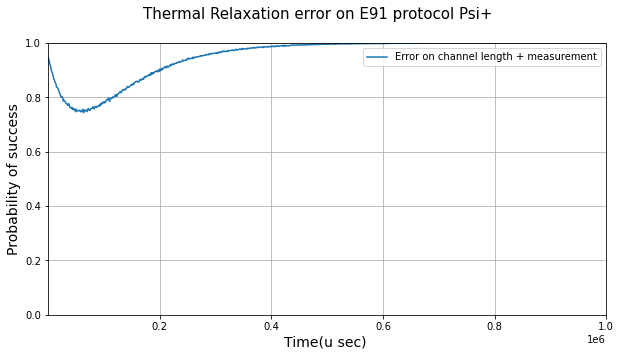

<Figure size 576x360 with 0 Axes>

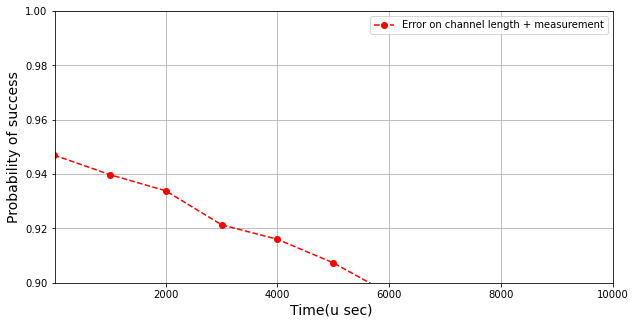

<Figure size 576x360 with 0 Axes>

In [33]:
%config InlineBackend.print_figure_kwargs={'facecolor' : "w"}
import matplotlib.pyplot as plt
from matplotlib.ticker import (AutoMinorLocator, MultipleLocator)
fig, ax = plt.subplots(figsize=(10, 5))
fig.suptitle('Thermal Relaxation error on E91 protocol Psi+',fontsize=15)
ax.set_xlim(10, 1000000)
ax.set_ylim(0,1)
plt.ylabel('Probability of success',fontsize=14)
plt.xlabel('Time(u sec) ',fontsize=14)
plt.grid()

fig = plt.figure(figsize=(8,5))
ax.plot(delay,c,label = "Error on channel length + measurement")
ax.legend()

#################################################################################

%config InlineBackend.print_figure_kwargs={'facecolor' : "w"}
import matplotlib.pyplot as plt
from matplotlib.ticker import (AutoMinorLocator, MultipleLocator)
fig, ax = plt.subplots(figsize=(10, 5))
#fig.suptitle('Thermal Relaxation error on E91 protocol',fontsize=15)
ax.set_xlim(10, 10000)
ax.set_ylim(0.9,1)
plt.ylabel('Probability of success',fontsize=14)
plt.xlabel('Time(u sec) ',fontsize=14)
plt.grid()
fig = plt.figure(figsize=(8,5))

ax.plot(delay,c,'ro--',label = "Error on channel length + measurement")
ax.legend()

In [51]:
import matplotlib.pyplot as plt

listofSuccess_DandM2=[]
for x in range(20): #loop for 20 times average
    delay = np.arange(0,1001000,1000)
    channel = '2'
    apply_error = {"delay":True, "measure": True, "gate": False}
    success = []

    # need to run in multiple loops to get a smoother curve
    for d in range(len(delay)):
        prob = run(channel,int(delay[d]),apply_error)
        success.append(prob)
    #print(success) Enable it to see the reading
    listofSuccess_DandM2.append(success)
    

In [52]:
from statistics import mean
a= listofSuccess_DandM2
print(*map(mean, zip(*a)))

0.94295 0.9328000000000001 0.92535 0.9129 0.9018 0.894 0.8858 0.8782 0.8688 0.85615 0.8481 0.8401 0.8285 0.8208 0.81135 0.80095 0.8008000000000001 0.78645 0.7807000000000001 0.77075 0.7645500000000001 0.75585 0.74525 0.73415 0.7303 0.72595 0.7117 0.7133499999999999 0.70175 0.69685 0.68 0.6782 0.66945 0.6626500000000001 0.6624 0.6513 0.6409 0.63625 0.63055 0.6214 0.6194999999999999 0.60935 0.6072 0.5969 0.59055 0.5799 0.57655 0.5729 0.5654 0.5578 0.554 0.5445500000000001 0.53905 0.53385 0.5295000000000001 0.5222 0.5181 0.51565 0.5149 0.50035 0.5006 0.4827 0.48455 0.48165 0.4746 0.4735 0.46715 0.4619 0.45325 0.4521 0.44325 0.44175 0.441 0.4352 0.42605 0.4201 0.42135 0.42164999999999997 0.4081 0.4062 0.4012 0.3975 0.39415 0.39275 0.38215 0.3786 0.37675 0.37295 0.3709 0.3658 0.35775 0.3596 0.35735 0.34965 0.3497 0.34385 0.3286 0.3337 0.33005 0.33165 0.3178 0.31465 0.32365 0.31685 0.30815 0.30119999999999997 0.3018 0.30245 0.3021 0.2903 0.29295 0.28905 0.28315 0.28435 0.2779 0.2755 0.28185 

In [55]:
c2=[0.94295,0.9328000000000001,0.92535,0.9129,0.9018,0.894,0.8858,0.8782,0.8688,0.85615,0.8481,0.8401,0.8285,0.8208,0.81135,0.80095,0.8008000000000001,0.78645,0.7807000000000001,0.77075,0.7645500000000001,0.75585,0.74525,0.73415,0.7303,0.72595,0.7117,0.7133499999999999,0.70175,0.69685,0.68,0.6782,0.66945,0.6626500000000001,0.6624,0.6513,0.6409,0.63625,0.63055,0.6214,0.6194999999999999,0.60935,0.6072,0.5969,0.59055,0.5799,0.57655,0.5729,0.5654,0.5578,0.554,0.5445500000000001,0.53905,0.53385,0.5295000000000001,0.5222,0.5181,0.51565,0.5149,0.50035,0.5006,0.4827,0.48455,0.48165,0.4746,0.4735,0.46715,0.4619,0.45325,0.4521,0.44325,0.44175,0.441,0.4352,0.42605,0.4201,0.42135,0.42164999999999997,0.4081,0.4062,0.4012,0.3975,0.39415,0.39275,0.38215,0.3786,0.37675,0.37295,0.3709,0.3658,0.35775,0.3596,0.35735,0.34965,0.3497,0.34385,0.3286,0.3337,0.33005,0.33165,0.3178,0.31465,0.32365,0.31685,0.30815,0.30119999999999997,0.3018,0.30245,0.3021,0.2903,0.29295,0.28905,0.28315,0.28435,0.2779,0.2755,0.28185,0.2669,0.26655,0.2655,0.26780000000000004,0.25680000000000003,0.25545,0.2556,0.24995,0.2468,0.24430000000000002,0.24375,0.2391,0.23905,0.2294,0.23045,0.2322,0.2297,0.2296,0.2225,0.2179,0.21625,0.2168,0.2135,0.2119,0.21125,0.2105,0.2115,0.19655,0.2006,0.2003,0.19675,0.1954,0.1934,0.1906,0.18384999999999999,0.1863,0.1872,0.18245,0.1789,0.17785,0.177,0.1744,0.17165,0.169,0.17055,0.1686,0.16755,0.16415,0.1603,0.1575,0.155,0.1554,0.15835,0.14415,0.156,0.14865,0.14495,0.14035,0.14529999999999998,0.1438,0.14049999999999999,0.14425,0.14279999999999998,0.13605,0.13565,0.1363,0.13475,0.13745,0.1332,0.12605,0.12675,0.1287,0.12545,0.12335,0.1215,0.1245,0.1157,0.11885,0.1202,0.1163,0.11595,0.1111,0.1159,0.11265,0.111,0.11215,0.1092,0.1118,0.1058,0.10215,0.1023,0.1011,0.1027,0.09915,0.0967,0.1011,0.10005,0.09585,0.09695,0.0898,0.0918,0.0939,0.0898,0.0927,0.0901,0.0906,0.09015000000000001,0.08245,0.084,0.08205,0.081,0.08125,0.0813,0.07895,0.0797,0.07905,0.07805,0.075,0.0747,0.0791,0.075,0.07175,0.0699,0.06955,0.0729,0.0665,0.06905,0.07015,0.0687,0.06865,0.06645,0.0644,0.0627,0.06465,0.0622,0.0628,0.06395,0.06335,0.06375,0.06095,0.060200000000000004,0.060200000000000004,0.06105,0.0579,0.0553,0.0553,0.0566,0.0546,0.0575,0.05635,0.0543,0.053649999999999996,0.0533,0.05175,0.05025,0.051949999999999996,0.05205,0.04825,0.0472,0.0491,0.0501,0.0484,0.04805,0.04595,0.04745,0.04425,0.0462,0.0431,0.0443,0.0474,0.0421,0.04325,0.041800000000000004,0.0439,0.04165,0.04045,0.03975,0.03805,0.0398,0.0377,0.0397,0.03735,0.03665,0.03555,0.03765,0.0378,0.0369,0.03435,0.038,0.03765,0.03875,0.03335,0.0338,0.0325,0.03325,0.03245,0.03335,0.032,0.0337,0.03055,0.031,0.03265,0.030350000000000002,0.0315,0.0307,0.03105,0.029400000000000003,0.02915,0.02855,0.03,0.02925,0.02775,0.029,0.0281,0.0273,0.027200000000000002,0.0265,0.02525,0.0248,0.02525,0.02675,0.0246,0.02485,0.0237,0.0227,0.0234,0.0231,0.0249,0.0242,0.0239,0.0217,0.021750000000000002,0.0217,0.023,0.02495,0.0207,0.0211,0.021249999999999998,0.02,0.0201,0.0187,0.02135,0.0208,0.0204,0.02155,0.02,0.01995,0.02035,0.019200000000000002,0.0176,0.01855,0.0182,0.01885,0.01795,0.01815,0.0185,0.0174,0.0172,0.01695,0.0169,0.01755,0.0176,0.01765,0.01555,0.01485,0.0161,0.0148,0.01405,0.01515,0.0147,0.0149,0.01525,0.0143,0.01555,0.01525,0.014199999999999999,0.014,0.0133,0.01465,0.01365,0.0134,0.01375,0.013,0.0128,0.0127,0.012,0.013349999999999999,0.01235,0.01245,0.01245,0.01275,0.0123,0.013,0.013,0.01145,0.012,0.01015,0.01145,0.01075,0.01025,0.0105,0.01125,0.012199999999999999,0.009,0.0102,0.01185,0.00935,0.00945,0.01,0.00985,0.00905,0.00995,0.0103,0.0097,0.00955,0.0115,0.00875,0.00865,0.0087,0.0076,0.0097,0.0083,0.00755,0.00955,0.0081,0.0075,0.00715,0.0092,0.00825,0.0072,0.00705,0.00855,0.008,0.00755,0.00745,0.00745,0.0069,0.00755,0.0067,0.00655,0.00755,0.0078,0.0072,0.0075,0.0064,0.00705,0.0064,0.0068000000000000005,0.00625,0.00615,0.0065,0.0067,0.00675,0.0059,0.0053,0.0061,0.0058,0.0056500000000000005,0.00525,0.00675,0.0051,0.0057,0.0054,0.00535,0.00585,0.00585,0.00525,0.00565,0.0056,0.0045,0.00535,0.005,0.00545,0.00495,0.0055,0.0045,0.00445,0.00535,0.0045000000000000005,0.00495,0.00525,0.00415,0.00455,0.00495,0.0044,0.0048000000000000004,0.0041,0.0033,0.0043,0.0046,0.00405,0.00425,0.00385,0.004,0.00345,0.00435,0.004,0.00385,0.0036,0.00335,0.00395,0.0032,0.0041,0.003,0.0035,0.004,0.0036,0.0031,0.0031,0.0036,0.0042,0.00315,0.0036,0.003,0.00355,0.0028,0.0028,0.00295,0.00275,0.00305,0.00335,0.00295,0.0026,0.0029000000000000002,0.00315,0.00315,0.0029000000000000002,0.0032,0.00295,0.00285,0.0019,0.0018,0.00255,0.00275,0.0025,0.00305,0.0028,0.0024000000000000002,0.0024000000000000002,0.0019500000000000001,0.00255,0.0027,0.0028,0.00205,0.00185,0.0025,0.0024000000000000002,0.00205,0.0022500000000000003,0.0026,0.00235,0.0022,0.00175,0.0018,0.00235,0.0019,0.00175,0.0023,0.0019500000000000001,0.00255,0.00205,0.00235,0.00205,0.00165,0.0024000000000000002,0.0023,0.002,0.0016,0.00165,0.00215,0.00215,0.0019,0.0018,0.0019,0.0015,0.0013,0.0012000000000000001,0.0015,0.0011,0.00185,0.0014,0.00185,0.00135,0.0013,0.00175,0.00155,0.0016,0.0012000000000000001,0.00155,0.0012000000000000001,0.00125,0.00175,0.0016,0.00165,0.00125,0.0016,0.0016,0.0013,0.00125,0.0014500000000000001,0.00115,0.00125,0.00135,0.00155,0.00155,0.0011,0.00155,0.00135,0.0014500000000000001,0.0018,0.0011,0.0008500000000000001,0.00165,0.0012000000000000001,0.0012000000000000001,0.00055,0.0007,0.0008500000000000001,0.0009,0.00125,0.0013,0.0008,0.0005,0.0009,0.0011,0.0008,0.0013,0.0009,0.001,0.0007,0.0009,0.0008500000000000001,0.0008500000000000001,0.00095,0.00075,0.001,0.00095,0.00135,0.001,0.0007,0.0008,0.00095,0.0008,0.0008,0.00105,0.0008500000000000001,0.0009,0.0005,0.0006000000000000001,0.0004,0.0004,0.0006000000000000001,0.0008,0.00055,0.00075,0.0006000000000000001,0.00075,0.00065,0.00075,0.00075,0.0005,0.0007,0.00065,0.0008,0.0008500000000000001,0.0004,0.00055,0.00065,0.00055,0.00030000000000000003,0.00065,0.0005,0.0005,0.00045,0.00065,0.0005,0.00065,0.00045,0.00025,0.00095,0.00075,0.0006000000000000001,0.0007,0.0006000000000000001,0.00055,0.0006000000000000001,0.00025,0.0004,0.0004,0.0004,0.0004,0.0005,0.0005,0.00030000000000000003,0.00055,0.00055,0.00030000000000000003,0.00025,0.00055,0.00045,0.00015000000000000001,0.0005,0.0004,0.0006000000000000001,0.00030000000000000003,0.0006000000000000001,0.00045,0.00030000000000000003,0.0007,0.00035,0.0004,0.00045,0.0002,0.00065,0.00035,0.0005,0.00035,0.00015000000000000001,0.00045,0.00030000000000000003,0.00035,0.0002,0.00035,0.00035,0.00025,0.00030000000000000003,0.0004,0.00045,0.00035,0.00025,0.00045,0.00025,0.00035,0.00015000000000000001,0.00025,0.00035,0.00015000000000000001,0.00035,0.00025,0.00025,0.00015000000000000001,0.00015000000000000001,0.00065,0.00045,0.0002,0.00030000000000000003,0.0001,0.0002,0.0004,0.00025,0.00015000000000000001,0.0004,0.00030000000000000003,0.00015000000000000001,0.0002,0.00015000000000000001,0.0005,0.00025,0.00015000000000000001,0.00030000000000000003,0.00045,0.0004,0.0001,0.00030000000000000003,0.00025,0.00030000000000000003,0.0001,0.00015000000000000001,0.00025,0.0002,0.00035,0.0002,0.0004,0.00015000000000000001,0.0005,0.0004,0.0002,0.00015000000000000001,0.0002,0.0002,0.00015000000000000001,0.0001,5e-05,5e-05,0.0,0.0002,0.0001,0.00025,0.0001,0.00025,0.00030000000000000003,5e-05,5e-05,0.0002,0.0001,0.0001,0.0001,0.0001,5e-05,0.0001,5e-05,0.00015000000000000001,0.00015000000000000001,0.0,0.0001,5e-05,0.0001,0.0,0.0001,0.00025,0.0001,0.0002,0.00015000000000000001,0.00015000000000000001,0.00015000000000000001,0.0001,5e-05,0.00015000000000000001,5e-05,0.00025,0.0001,0.00015000000000000001,0.0001,5e-05,0.00035,0.00015000000000000001,0.0001,0.0002,0.0001,0.00015000000000000001,0.0,0.0001,0.0001,0.0001,0.0,0.0002,0.00025,0.0,5e-05,5e-05,5e-05,5e-05,5e-05,0.00015000000000000001,0.0001,0.0,5e-05,5e-05,0.0,0.0001,0.0001,0.00015000000000000001,0.0001,5e-05,0.0,5e-05,0.00015000000000000001,0.0001,0.0001,5e-05,0.0,5e-05,5e-05,5e-05,5e-05,0.0001,0.0001,0.0001,0.0,0.0,5e-05,0.0,5e-05,5e-05,5e-05,0.0001,0.0001,0.0,0.0,0.0,0.0001,5e-05,0.0,0.0001,0.00015000000000000001,0.0001,0.0001,0.0,5e-05,0.0,0.0,0.0,0.0,0.0001,5e-05,0.0,0.0001,0.00015000000000000001,0.0,5e-05,0.0001,0.00015000000000000001,0.0,0.0001,0.0,0.0,0.0,0.0,0.00015000000000000001,5e-05,5e-05,0.0,0.0,0.0001,0.0,5e-05,0.0,0.0001,0.0,0.0,5e-05,0.0001,0.0001,0.0,5e-05,0.0,5e-05,5e-05,5e-05,5e-05,5e-05,0.0001,0.0001,0.0,0.0,5e-05,0.0001,0.0,0.0001,0.0001,5e-05,0.0,0.0,0.0,5e-05,0.0,0.0,0.0,0.0001,5e-05,0.0,0.0,0.0,0.0,0.0,5e-05,5e-05,5e-05,5e-05,0.0,0.0,5e-05,0.0001,0.0,0.0001,0.0,0.0,0.0,5e-05,5e-05,0.00015000000000000001,0.0,0.0,5e-05,5e-05,0.0,0.0,0.0,5e-05,5e-05,5e-05,5e-05,0.0,0.0]


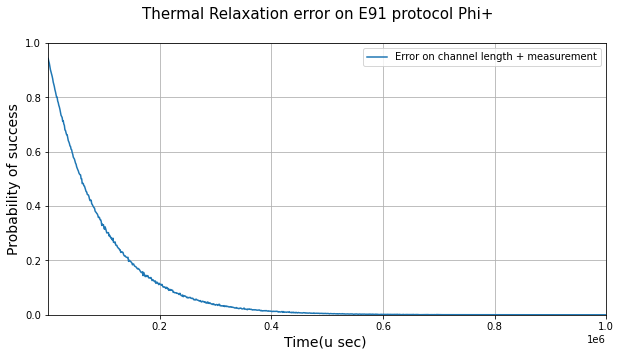

<Figure size 576x360 with 0 Axes>

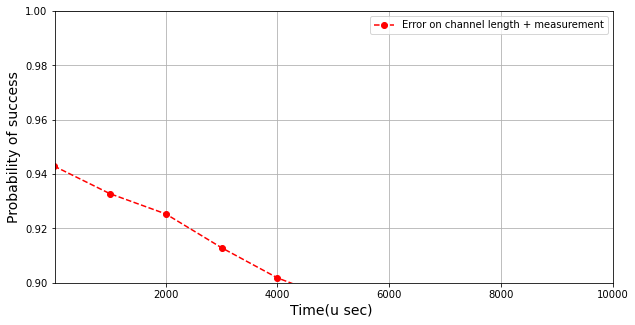

<Figure size 576x360 with 0 Axes>

In [56]:
%config InlineBackend.print_figure_kwargs={'facecolor' : "w"}
import matplotlib.pyplot as plt
from matplotlib.ticker import (AutoMinorLocator, MultipleLocator)
fig, ax = plt.subplots(figsize=(10, 5))
fig.suptitle('Thermal Relaxation error on E91 protocol Phi+',fontsize=15)
ax.set_xlim(10, 1000000)
ax.set_ylim(0,1)
plt.ylabel('Probability of success',fontsize=14)
plt.xlabel('Time(u sec) ',fontsize=14)
plt.grid()

fig = plt.figure(figsize=(8,5))
ax.plot(delay,c2,label = "Error on channel length + measurement")
ax.legend()

#################################################################################

%config InlineBackend.print_figure_kwargs={'facecolor' : "w"}
import matplotlib.pyplot as plt
from matplotlib.ticker import (AutoMinorLocator, MultipleLocator)
fig, ax = plt.subplots(figsize=(10, 5))
#fig.suptitle('Thermal Relaxation error on E91 protocol',fontsize=15)
ax.set_xlim(10, 10000)
ax.set_ylim(0.9,1)
plt.ylabel('Probability of success',fontsize=14)
plt.xlabel('Time(u sec) ',fontsize=14)
plt.grid()
fig = plt.figure(figsize=(8,5))

ax.plot(delay,c2,'ro--',label = "Error on channel length + measurement")
ax.legend()

# Delay, Measure and Gate

In [30]:
import matplotlib.pyplot as plt

listofSuccess_DMG=[]
for x in range(20): #loop for 20 times average
    delay = np.arange(0,1001000,1000)
    channel = '1'
    apply_error = {"delay":True, "measure": True, "gate": True}
    success = []

    # need to run in multiple loops to get a smoother curve
    for d in range(len(delay)):
        prob = run(channel,int(delay[d]),apply_error)
        success.append(prob)
    #print(success) Enable it to see the reading
    listofSuccess_DMG.append(success)
    

In [31]:
from statistics import mean
a= listofSuccess_DMG
print(*map(mean, zip(*a)))

0.9454 0.9376 0.9251 0.9167500000000001 0.9145000000000001 0.9003 0.896 0.89105 0.8817 0.8737 0.8697 0.86355 0.86205 0.8569 0.84355 0.84505 0.8363499999999999 0.8274499999999999 0.82735 0.82175 0.8131 0.8113 0.8057 0.8072 0.8034 0.8014 0.7905500000000001 0.79635 0.7894 0.7889 0.78225 0.78325 0.77775 0.7791 0.7768 0.7767000000000001 0.7657 0.7649 0.75875 0.7674 0.76095 0.7686000000000001 0.7629 0.7628 0.76005 0.75305 0.75515 0.7532 0.7494 0.7518 0.7559 0.75165 0.75425 0.7482 0.7545 0.7484999999999999 0.75555 0.74955 0.74445 0.7483 0.75395 0.75025 0.74805 0.74865 0.75085 0.75175 0.7492 0.7489 0.75275 0.7573 0.75055 0.7519 0.75315 0.7534 0.7512 0.75685 0.75895 0.7538 0.76315 0.7558 0.75485 0.7637 0.7634 0.7602 0.7594 0.76515 0.76545 0.7664 0.76595 0.7734 0.7726000000000001 0.77215 0.77085 0.77485 0.7762 0.77545 0.7825500000000001 0.77825 0.7777000000000001 0.77975 0.7751 0.7778 0.7836000000000001 0.7856500000000001 0.78285 0.7864 0.78695 0.7911 0.7919 0.7977500000000001 0.79535 0.79735 0.

In [62]:
d=[0.9454,0.9376,0.9251,0.9167500000000001,0.9145000000000001,0.9003,0.896,0.89105,0.8817,0.8737,0.8697,0.86355,0.86205,0.8569,0.84355,0.84505,0.8363499999999999,0.8274499999999999,0.82735,0.82175,0.8131,0.8113,0.8057,0.8072,0.8034,0.8014,0.7905500000000001,0.79635,0.7894,0.7889,0.78225,0.78325,0.77775,0.7791,0.7768,0.7767000000000001,0.7657,0.7649,0.75875,0.7674,0.76095,0.7686000000000001,0.7629,0.7628,0.76005,0.75305,0.75515,0.7532,0.7494,0.7518,0.7559,0.75165,0.75425,0.7482,0.7545,0.7484999999999999,0.75555,0.74955,0.74445,0.7483,0.75395,0.75025,0.74805,0.74865,0.75085,0.75175,0.7492,0.7489,0.75275,0.7573,0.75055,0.7519,0.75315,0.7534,0.7512,0.75685,0.75895,0.7538,0.76315,0.7558,0.75485,0.7637,0.7634,0.7602,0.7594,0.76515,0.76545,0.7664,0.76595,0.7734,0.7726000000000001,0.77215,0.77085,0.77485,0.7762,0.77545,0.7825500000000001,0.77825,0.7777000000000001,0.77975,0.7751,0.7778,0.7836000000000001,0.7856500000000001,0.78285,0.7864,0.78695,0.7911,0.7919,0.7977500000000001,0.79535,0.79735,0.802,0.79435,0.7987000000000001,0.80755,0.8012,0.8036500000000001,0.8044,0.80535,0.80845,0.8098,0.81275,0.8069500000000001,0.81945,0.81195,0.81715,0.8136,0.81855,0.81865,0.8181499999999999,0.8228,0.8275,0.823,0.82785,0.82765,0.8319,0.83165,0.8343499999999999,0.83275,0.83065,0.8354499999999999,0.8401,0.84065,0.8398,0.84485,0.8407,0.8453999999999999,0.8441,0.8438,0.8457,0.8503999999999999,0.8488,0.8512,0.85365,0.85395,0.8543499999999999,0.8557,0.86085,0.85775,0.8621,0.8558,0.8628,0.858,0.8641,0.8632,0.8689,0.8696,0.86735,0.8742,0.8701,0.87235,0.8778,0.8731,0.8733,0.87775,0.87565,0.8789,0.87765,0.8793,0.88285,0.88055,0.88105,0.8856,0.8823,0.88485,0.88725,0.89285,0.89375,0.8925500000000001,0.8918,0.89125,0.89595,0.8918,0.8945000000000001,0.9007000000000001,0.8986000000000001,0.8997,0.89375,0.9015500000000001,0.9005500000000001,0.9021,0.90225,0.9016500000000001,0.90295,0.9056000000000001,0.90705,0.9096000000000001,0.9087000000000001,0.91025,0.9091,0.9111,0.9132,0.91425,0.91695,0.9181,0.91715,0.91505,0.91945,0.9183,0.9153,0.9215500000000001,0.92115,0.92415,0.9183,0.92405,0.92125,0.92545,0.9248500000000001,0.9272,0.9277000000000001,0.92645,0.92305,0.92695,0.93035,0.9265,0.9298000000000001,0.9319000000000001,0.9347,0.934,0.9337,0.9348,0.9371,0.93555,0.9359500000000001,0.9373,0.9337500000000001,0.9351,0.93695,0.94275,0.9369,0.9396,0.94,0.9416,0.94145,0.9435,0.9432499999999999,0.9443499999999999,0.9461999999999999,0.94585,0.94885,0.94475,0.9441499999999999,0.9481999999999999,0.94855,0.94875,0.94905,0.9492499999999999,0.95005,0.9522999999999999,0.95155,0.95385,0.9524999999999999,0.9531999999999999,0.9519,0.9522499999999999,0.9536,0.9561,0.9561499999999999,0.957,0.9541999999999999,0.9533499999999999,0.958,0.9564499999999999,0.9573999999999999,0.9579,0.9567,0.95865,0.9582499999999999,0.9591999999999999,0.9604999999999999,0.96,0.9596,0.9612999999999999,0.9613999999999999,0.9621,0.9602499999999999,0.96415,0.9611,0.9618,0.96375,0.96575,0.9649,0.9655,0.96585,0.9648,0.9646,0.96895,0.9684499999999999,0.967,0.96675,0.9675,0.9683499999999999,0.96905,0.9679,0.969,0.96885,0.9694499999999999,0.96965,0.96995,0.9713999999999999,0.97,0.9713499999999999,0.97275,0.9703999999999999,0.9724999999999999,0.9714499999999999,0.9723499999999999,0.97455,0.9713999999999999,0.9714499999999999,0.97275,0.9732,0.9723999999999999,0.975,0.97425,0.97555,0.97475,0.97555,0.9763999999999999,0.97595,0.97815,0.9754499999999999,0.97705,0.9768,0.9772,0.97805,0.9772,0.9793,0.9776,0.9793,0.9792,0.97695,0.9783999999999999,0.97885,0.9803499999999999,0.979,0.97955,0.97965,0.9822,0.9808,0.9811,0.98025,0.98125,0.98255,0.98055,0.9843,0.9808,0.98315,0.9823,0.9823,0.98205,0.98375,0.98215,0.9824999999999999,0.98295,0.983,0.98395,0.9833,0.9844999999999999,0.98415,0.9822,0.9854499999999999,0.98365,0.9837,0.9844999999999999,0.9842,0.98405,0.98555,0.9847,0.9861,0.98605,0.9859,0.9859,0.9853,0.98795,0.98565,0.98665,0.98695,0.98605,0.9881,0.98715,0.98775,0.98705,0.98855,0.9873,0.98755,0.98925,0.98835,0.98705,0.987,0.9869,0.9888,0.98895,0.98715,0.989,0.9889,0.9891,0.9906,0.9907,0.9891,0.9901,0.9898,0.99005,0.9904999999999999,0.9894499999999999,0.9884,0.9897,0.992,0.9907,0.9903,0.99115,0.9914,0.9916,0.9904999999999999,0.99125,0.9914,0.99225,0.9911,0.99275,0.9911,0.99205,0.9922,0.99175,0.9924499999999999,0.9911,0.9913,0.993,0.99105,0.993,0.9934499999999999,0.9931,0.99265,0.99285,0.993,0.99265,0.99335,0.99325,0.99315,0.9938,0.9938,0.99335,0.99275,0.9942,0.9937,0.99385,0.9936,0.9937,0.99455,0.99315,0.99265,0.99425,0.9936,0.99475,0.99485,0.9946,0.9934,0.9952,0.9947,0.9932,0.9935,0.99395,0.9946,0.9937,0.9942,0.9964,0.99465,0.9946,0.99515,0.9948,0.9958,0.99565,0.99555,0.99545,0.9963,0.99515,0.9953,0.9954,0.9955,0.99525,0.9958,0.99595,0.99515,0.99545,0.9959,0.99645,0.99575,0.9957,0.996,0.9955,0.99555,0.996,0.9957,0.996,0.9963,0.99615,0.9962,0.99545,0.99675,0.99725,0.99685,0.9956,0.9973,0.9962,0.9963,0.99705,0.9964,0.9961,0.9968,0.9973,0.9972,0.9962,0.99735,0.9972,0.9962,0.9964999999999999,0.9973,0.99705,0.9976,0.9973,0.99785,0.9971,0.9974,0.9971,0.99725,0.99655,0.9976,0.9973,0.99755,0.99735,0.99705,0.99775,0.99755,0.99765,0.99755,0.9977,0.9976,0.99805,0.9972,0.9981,0.99795,0.99765,0.99745,0.99755,0.9979,0.99795,0.9979,0.9979,0.9975,0.99765,0.9979,0.9981,0.9981,0.9979,0.99785,0.99825,0.9977,0.999,0.99735,0.99845,0.9986,0.9982,0.99775,0.99845,0.9981,0.9987,0.99775,0.99855,0.9981,0.9977,0.9983,0.99865,0.99835,0.99805,0.9984,0.9981,0.9986,0.999,0.99865,0.99855,0.99835,0.99825,0.99845,0.9981,0.9984,0.99865,0.99905,0.99865,0.9989,0.9987,0.99825,0.9989,0.99855,0.9983,0.99875,0.9983,0.99875,0.99885,0.9984999999999999,0.9988,0.9986,0.99855,0.99875,0.99935,0.99875,0.99905,0.99865,0.99925,0.9987,0.9987,0.99905,0.999,0.99855,0.99895,0.99915,0.99865,0.999,0.9994,0.9989,0.9992,0.9988,0.9987,0.9984999999999999,0.99925,0.999,0.9993,0.99865,0.9987,0.99925,0.99885,0.99905,0.9994,0.99905,0.99905,0.99895,0.9992,0.9993,0.999,0.9992,0.9991,0.9994,0.99935,0.999,0.99955,0.99935,0.99935,0.999,0.99955,0.99905,0.99925,0.999,0.99935,0.9993,0.9995,0.99955,0.99945,0.9991,0.99935,0.9993,0.99945,0.9995,0.9996,0.99905,0.99905,0.99945,0.9994,0.9994,0.9993,0.9995,0.9995,0.99945,0.99945,0.9997,0.99935,0.99935,0.9997,0.9995,0.99965,0.99935,0.99965,0.9996,0.9995,0.99935,0.9992,0.99955,0.9996,0.99955,0.9994,0.99935,0.9995,0.9995,0.99955,0.9995,0.9995,0.99965,0.99945,0.99955,0.99965,0.99935,0.9995,0.99965,0.9997,0.99955,0.99975,0.9993,0.99955,0.99955,0.9996,0.9996,0.9996,0.9997,0.99965,0.9997,0.9995,0.9999,0.9996,0.99955,0.9995,0.99975,0.9995,0.99965,0.9997,0.9997,0.9997,0.9997,0.9997,0.9997,0.99975,0.9994,0.99965,0.99975,0.9997,0.99975,0.9995,0.99995,0.99985,0.99945,0.9998,0.9997,0.99945,0.99985,0.99975,0.9996,0.9997,0.99975,0.9998,0.99965,0.9996,0.9998,0.99985,0.9997,0.99965,0.9997,0.99975,0.99955,0.9998,0.99965,0.99955,0.9996,0.9999,0.99985,0.99985,0.99985,0.99985,0.9997,0.99985,0.9998,0.99985,0.99975,0.9999,0.9999,0.99985,0.9997,0.9997,0.99985,0.99995,0.99985,0.99995,0.99975,0.9997,0.99985,0.9998,0.99985,0.99975,0.9997,0.99985,0.99995,0.99985,0.9999,0.99975,0.9997,0.9998,0.9999,0.99985,0.99995,0.9998,0.9999,0.99975,1.0,0.99995,0.99985,0.99995,0.9998,0.99985,1.0,0.9998,0.99975,0.9998,0.9999,0.9998,0.9999,0.99995,0.9999,0.99995,0.99985,0.9998,0.99985,0.99975,0.99975,0.99985,1.0,0.99985,1.0,0.99995,0.9999,0.99995,0.99985,0.99985,0.9998,0.99985,0.9999,0.9998,0.99985,0.99995,0.99995,0.9997,0.99995,1.0,1.0,0.9999,0.9999,0.9999,1.0,0.9999,0.99995,0.99995,0.99995,1.0,0.99995,0.99995,0.9999,0.99995,0.9999,0.99995,1.0,0.9999,0.99995,0.99995,1.0,0.99985,0.99995,0.99975,1.0,0.9999,1.0,0.9999,0.99995,1.0,0.9999,0.99995,0.9998,0.99995,1.0,0.99995,0.99995,1.0,0.99995,1.0,1.0,0.9999,1.0,0.99995,1.0,0.9999,1.0,0.99995,0.99995,0.99995,1.0,0.99995,0.99995,0.99995,0.99995,0.99985,1.0,0.99995,1.0,0.9999,1.0,0.9999,1.0,1.0,1.0,0.99995,1.0,0.99985,0.99995,0.99995,1.0,0.9999,0.99995,0.99995,1.0,1.0,1.0,0.99995,1.0,1.0,0.9999,0.99995,0.99985,1.0,1.0,0.99995,0.99995,1.0,1.0,0.99995,0.99995,0.99995,0.9999,0.99995,1.0,1.0,0.99995,0.99995,1.0,0.99995,1.0,1.0,1.0,1.0,1.0,0.9999,1.0,0.9999,1.0,1.0,0.99995,1.0,0.99995,1.0,0.9999,1.0,1.0,0.9999,0.99995,1.0,1.0,0.99995,1.0,1.0,1.0,1.0,1.0,0.99995,0.99995,0.99995,1.0,1.0,1.0,1.0,1.0,1.0,0.99995,1.0,0.99995,1.0,1.0,0.99995,0.99995]

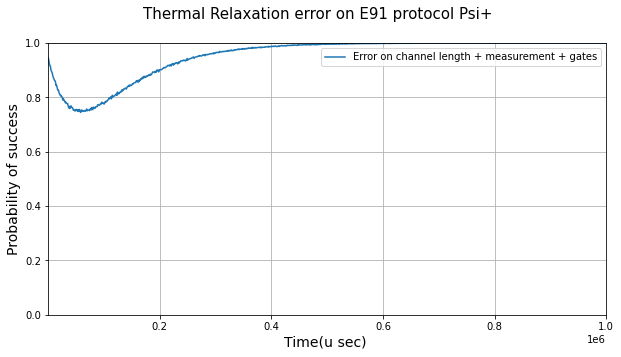

<Figure size 576x360 with 0 Axes>

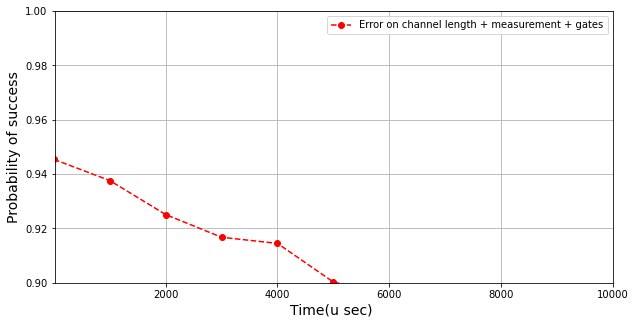

<Figure size 576x360 with 0 Axes>

In [63]:
%config InlineBackend.print_figure_kwargs={'facecolor' : "w"}
import matplotlib.pyplot as plt
from matplotlib.ticker import (AutoMinorLocator, MultipleLocator)
fig, ax = plt.subplots(figsize=(10, 5))
fig.suptitle('Thermal Relaxation error on E91 protocol Psi+',fontsize=15)
ax.set_xlim(10, 1000000)
ax.set_ylim(0,1)
plt.ylabel('Probability of success',fontsize=14)
plt.xlabel('Time(u sec) ',fontsize=14)
plt.grid()

fig = plt.figure(figsize=(8,5))
ax.plot(delay,d,label = "Error on channel length + measurement + gates")
ax.legend()

#################################################################################

%config InlineBackend.print_figure_kwargs={'facecolor' : "w"}
import matplotlib.pyplot as plt
from matplotlib.ticker import (AutoMinorLocator, MultipleLocator)
fig, ax = plt.subplots(figsize=(10, 5))
#fig.suptitle('Thermal Relaxation error on E91 protocol',fontsize=15)
ax.set_xlim(10, 10000)
ax.set_ylim(0.9,1)
plt.ylabel('Probability of success',fontsize=14)
plt.xlabel('Time(u sec) ',fontsize=14)
plt.grid()
fig = plt.figure(figsize=(8,5))

ax.plot(delay,d,'ro--',label = "Error on channel length + measurement + gates")
ax.legend()

In [47]:
import matplotlib.pyplot as plt

listofSuccess_DMG=[]
for x in range(20): #loop for 20 times average
    delay = np.arange(0,1001000,1000)
    channel = '2'
    apply_error = {"delay":True, "measure": True, "gate": True}
    success = []

    # need to run in multiple loops to get a smoother curve
    for d in range(len(delay)):
        prob = run(channel,int(delay[d]),apply_error)
        success.append(prob)
    #print(success) Enable it to see the reading
    listofSuccess_DMG.append(success)
    

In [48]:
from statistics import mean
a= listofSuccess_DMG
print(*map(mean, zip(*a)))

0.94095 0.93005 0.9194 0.9074 0.9018 0.8901 0.88165 0.86935 0.86325 0.85575 0.8449 0.8351 0.8222499999999999 0.8188 0.8103 0.7998500000000001 0.7836500000000001 0.7857000000000001 0.77845 0.7623 0.75775 0.7491 0.7434 0.73835 0.72615 0.71955 0.7172499999999999 0.7112999999999999 0.6947 0.6913 0.68635 0.6802 0.6617000000000001 0.6624 0.6545000000000001 0.64435 0.64135 0.64375 0.63295 0.62085 0.61225 0.5979 0.5984499999999999 0.5892499999999999 0.5862999999999999 0.5837 0.5763 0.57665 0.561 0.5578 0.54545 0.5357500000000001 0.5352 0.53645 0.5296000000000001 0.51765 0.50975 0.5141 0.5105 0.4957 0.4961 0.48815 0.4797 0.478 0.4766 0.46385 0.46055 0.46155 0.45115 0.44535 0.4521 0.44305 0.43535 0.43135 0.42719999999999997 0.4229 0.4123 0.41145 0.40795 0.40325 0.4038 0.3942 0.38155 0.3871 0.3819 0.37795 0.37645 0.36685 0.36685 0.36265 0.3571 0.354 0.3509 0.34505 0.34265 0.33925 0.33715 0.3318 0.33145 0.32775 0.3215 0.3191 0.3144 0.3143 0.30755 0.30115 0.2998 0.2969 0.29745 0.28935 0.2889 0.2865

In [53]:
d2=[0.94095,0.93005,0.9194,0.9074,0.9018,0.8901,0.88165,0.86935,0.86325,0.85575,0.8449,0.8351,0.8222499999999999,0.8188,0.8103,0.7998500000000001,0.7836500000000001,0.7857000000000001,0.77845,0.7623,0.75775,0.7491,0.7434,0.73835,0.72615,0.71955,0.7172499999999999,0.7112999999999999,0.6947,0.6913,0.68635,0.6802,0.6617000000000001,0.6624,0.6545000000000001,0.64435,0.64135,0.64375,0.63295,0.62085,0.61225,0.5979,0.5984499999999999,0.5892499999999999,0.5862999999999999,0.5837,0.5763,0.57665,0.561,0.5578,0.54545,0.5357500000000001,0.5352,0.53645,0.5296000000000001,0.51765,0.50975,0.5141,0.5105,0.4957,0.4961,0.48815,0.4797,0.478,0.4766,0.46385,0.46055,0.46155,0.45115,0.44535,0.4521,0.44305,0.43535,0.43135,0.42719999999999997,0.4229,0.4123,0.41145,0.40795,0.40325,0.4038,0.3942,0.38155,0.3871,0.3819,0.37795,0.37645,0.36685,0.36685,0.36265,0.3571,0.354,0.3509,0.34505,0.34265,0.33925,0.33715,0.3318,0.33145,0.32775,0.3215,0.3191,0.3144,0.3143,0.30755,0.30115,0.2998,0.2969,0.29745,0.28935,0.2889,0.2865,0.28085,0.2779,0.27885,0.27075,0.27045,0.27040000000000003,0.26165,0.2624,0.25485,0.2572,0.2532,0.24935000000000002,0.2508,0.24525,0.24525,0.24130000000000001,0.23725,0.23855,0.23245,0.23095,0.23025,0.2253,0.21985,0.22115,0.21595,0.2202,0.21245,0.21295,0.20145,0.21030000000000001,0.19695000000000001,0.2069,0.209,0.1999,0.19405,0.19705,0.1926,0.1896,0.1922,0.1866,0.1851,0.1842,0.17980000000000002,0.18025,0.18035,0.17505,0.1742,0.1693,0.17654999999999998,0.1679,0.1641,0.16675,0.15965000000000001,0.1589,0.1601,0.15795,0.15885,0.15615,0.155,0.15215,0.14475,0.15,0.1471,0.14765,0.14125,0.14245,0.1398,0.1431,0.13645,0.13995,0.1352,0.13135,0.129,0.12795,0.1286,0.12890000000000001,0.12585,0.1225,0.1259,0.11765,0.11865,0.1225,0.1198,0.1195,0.11195,0.11410000000000001,0.10775,0.1124,0.11145,0.10995,0.11175,0.1083,0.10675,0.10535,0.1018,0.10365,0.1048,0.0968,0.09815,0.0996,0.0986,0.09505,0.0977,0.0906,0.09475,0.0932,0.09129999999999999,0.08895,0.08925,0.08745,0.0884,0.0853,0.08805,0.08325,0.0809,0.086,0.08305,0.08234999999999999,0.0795,0.0823,0.07805,0.07680000000000001,0.08085,0.0793,0.07465,0.07495,0.07355,0.0739,0.07135,0.07115,0.06965,0.0711,0.06885,0.0662,0.0658,0.0656,0.06415,0.0665,0.0653,0.062,0.06115,0.0641,0.060200000000000004,0.05945,0.06225,0.0635,0.0581,0.06115,0.05725,0.0569,0.05465,0.0569,0.05465,0.055,0.0585,0.0533,0.0524,0.0524,0.0528,0.051449999999999996,0.0487,0.04945,0.05175,0.04745,0.04945,0.049049999999999996,0.04865,0.04465,0.04725,0.0469,0.0453,0.0446,0.046849999999999996,0.0438,0.04465,0.0434,0.04335,0.0428,0.0417,0.03955,0.04135,0.0408,0.0401,0.04,0.0383,0.03865,0.0403,0.0376,0.0389,0.0383,0.0374,0.03305,0.03645,0.0352,0.0344,0.036,0.03465,0.0377,0.03235,0.03265,0.03535,0.03365,0.034,0.0323,0.031,0.0314,0.030350000000000002,0.02985,0.0303,0.0305,0.02965,0.03025,0.02915,0.02835,0.02855,0.0294,0.0293,0.0288,0.02595,0.030100000000000002,0.02605,0.02695,0.02465,0.02455,0.0263,0.0254,0.0256,0.02365,0.02365,0.025,0.0233,0.02525,0.02345,0.02305,0.02355,0.02385,0.02265,0.02265,0.0222,0.0219,0.0208,0.02045,0.021249999999999998,0.01815,0.02055,0.0216,0.02015,0.01865,0.02115,0.0194,0.0195,0.02005,0.01745,0.01995,0.0183,0.02,0.01575,0.01825,0.01815,0.01575,0.01825,0.01795,0.0178,0.0164,0.0146,0.01655,0.0164,0.0163,0.0174,0.01705,0.01415,0.015050000000000001,0.0165,0.01435,0.01515,0.01585,0.0153,0.0141,0.01465,0.015600000000000001,0.01355,0.0135,0.0137,0.01455,0.01435,0.01345,0.0137,0.01275,0.0136,0.01365,0.01215,0.01315,0.01165,0.0133,0.0134,0.0126,0.01245,0.0132,0.01265,0.01175,0.0117,0.01175,0.011899999999999999,0.01045,0.01115,0.01065,0.01165,0.0102,0.0118,0.0112,0.00965,0.0091,0.01,0.01115,0.01025,0.0095,0.0096,0.00945,0.0095,0.00935,0.0091,0.00905,0.0089,0.00855,0.00855,0.00835,0.00785,0.00815,0.00885,0.00735,0.00805,0.0088,0.0084,0.00755,0.00985,0.00775,0.00815,0.00895,0.00725,0.0081,0.00775,0.00695,0.00745,0.00715,0.008,0.00695,0.0059,0.0063,0.00795,0.00705,0.007,0.0072,0.0059,0.00675,0.0056,0.0073,0.00675,0.0058,0.0066,0.00625,0.0064,0.00595,0.0055,0.0055,0.00645,0.0061,0.00555,0.00495,0.00585,0.0048000000000000004,0.00625,0.005,0.00505,0.0052,0.00585,0.00435,0.0046,0.0042,0.0054,0.00485,0.00465,0.00595,0.00575,0.0056500000000000005,0.0041,0.00425,0.0046,0.004,0.00495,0.00495,0.0045,0.00445,0.0041,0.00485,0.00495,0.00415,0.0039000000000000003,0.0041,0.00365,0.00385,0.0044,0.00455,0.0045,0.00385,0.0035,0.00435,0.00435,0.0035,0.0045000000000000005,0.0033,0.0026,0.0032,0.0035,0.00315,0.0041,0.0032,0.00365,0.00335,0.0025,0.00345,0.0028,0.00285,0.00245,0.0027,0.0045,0.00265,0.0028,0.00235,0.0028,0.0032,0.0031,0.0024000000000000002,0.0024000000000000002,0.00275,0.0023,0.00245,0.00245,0.0025,0.00285,0.0028,0.00265,0.0033,0.00245,0.0026,0.00265,0.0019,0.0024000000000000002,0.0026,0.00245,0.0022500000000000003,0.0022,0.0022500000000000003,0.0025,0.00165,0.00275,0.00245,0.00175,0.0023,0.0024000000000000002,0.0018,0.0023,0.0016,0.00205,0.00255,0.0022,0.00255,0.002,0.0015,0.00235,0.00155,0.0016,0.0013,0.0014500000000000001,0.002,0.0019500000000000001,0.0024000000000000002,0.0014500000000000001,0.00135,0.0019500000000000001,0.0018,0.0017000000000000001,0.0019,0.0019500000000000001,0.0015,0.0018,0.0017000000000000001,0.00115,0.00165,0.0015,0.00165,0.0014500000000000001,0.00185,0.00125,0.00175,0.0014,0.0013,0.00165,0.0012000000000000001,0.0015,0.0012000000000000001,0.0015,0.00115,0.0014,0.0014500000000000001,0.00165,0.00175,0.00075,0.0013,0.00125,0.00105,0.0008,0.00135,0.00115,0.00115,0.001,0.0007,0.00105,0.0015,0.0008500000000000001,0.00075,0.0014,0.0008,0.00135,0.0013,0.0008,0.0011,0.00115,0.0008500000000000001,0.001,0.0009,0.001,0.00105,0.0009,0.0004,0.0008500000000000001,0.0013,0.00055,0.00105,0.00075,0.00075,0.0013,0.00075,0.001,0.00065,0.0012000000000000001,0.0007,0.00095,0.0008,0.00095,0.0004,0.00075,0.001,0.0008,0.0009,0.00055,0.00065,0.00125,0.00065,0.0006000000000000001,0.0011,0.00065,0.00045,0.0004,0.00065,0.0008500000000000001,0.00055,0.00045,0.0006000000000000001,0.00055,0.00055,0.0006000000000000001,0.00075,0.0009,0.0008,0.0004,0.00045,0.00075,0.00065,0.00055,0.0008,0.0004,0.0006000000000000001,0.0004,0.0008,0.0007,0.00055,0.00075,0.00055,0.0006000000000000001,0.00065,0.00025,0.0006000000000000001,0.0005,0.00035,0.00075,0.00065,0.00030000000000000003,0.0006000000000000001,0.00055,0.00055,0.0008500000000000001,0.0006000000000000001,0.00055,0.00030000000000000003,0.00030000000000000003,0.0002,0.00030000000000000003,0.00045,0.0006000000000000001,0.0006000000000000001,0.00065,0.0005,0.00025,0.00025,0.0004,0.0004,0.0005,0.00025,0.00030000000000000003,0.00035,0.00045,0.00015000000000000001,0.0002,0.0004,0.00035,0.00015000000000000001,0.0004,0.00015000000000000001,0.0004,0.00035,0.00045,0.00045,0.0004,0.0004,0.00045,0.00025,0.00045,0.0002,0.00025,0.00030000000000000003,0.00030000000000000003,0.00030000000000000003,0.00015000000000000001,0.00030000000000000003,0.00025,0.0001,0.00015000000000000001,0.00015000000000000001,0.00025,5e-05,0.00025,0.00030000000000000003,0.00030000000000000003,0.00025,0.00035,0.0004,0.00015000000000000001,0.00025,0.0001,0.00035,0.00030000000000000003,0.0002,0.00015000000000000001,0.00025,0.00025,0.0002,0.00025,0.0002,0.00025,0.00015000000000000001,0.0001,0.00025,0.00015000000000000001,0.00025,0.00015000000000000001,0.0001,0.0002,0.0004,0.0002,0.00030000000000000003,0.00030000000000000003,0.00025,0.0002,0.00015000000000000001,0.0001,0.0002,0.0001,5e-05,5e-05,0.00025,0.0002,0.00015000000000000001,0.0002,0.0004,0.0001,0.0001,0.00030000000000000003,0.0001,5e-05,0.0001,0.0002,0.00015000000000000001,0.0002,0.00015000000000000001,0.0002,0.0002,0.00015000000000000001,0.0002,0.00030000000000000003,0.00025,0.0001,0.0001,0.0002,0.00030000000000000003,0.00025,0.0001,0.0002,0.0002,0.00025,0.0001,0.00015000000000000001,5e-05,0.0002,0.0002,5e-05,0.00015000000000000001,0.00015000000000000001,5e-05,0.0001,5e-05,5e-05,0.0001,0.0001,0.00015000000000000001,5e-05,0.0001,5e-05,0.0001,0.0001,5e-05,0.00015000000000000001,0.0,0.0,0.00030000000000000003,0.0001,0.0001,0.00035,0.0001,0.0,5e-05,0.0001,5e-05,0.0,0.0,0.00015000000000000001,0.00015000000000000001,0.0001,0.0001,0.00015000000000000001,0.0,0.0,5e-05,0.0002,5e-05,0.0002,5e-05,0.0001,0.0001,5e-05,0.0001,0.00015000000000000001,0.0,5e-05,0.0,0.0001,0.0002,5e-05,0.0,5e-05,5e-05,0.00015000000000000001,0.0,0.0001,5e-05,0.0,0.00025,5e-05,0.0001,5e-05,5e-05,5e-05,0.0,0.0001,5e-05,5e-05,0.0001,0.0001,0.0,0.0,0.0,0.0001,0.0001,5e-05,0.0,0.0001,0.0,0.00015000000000000001,0.0,0.0001,0.0,5e-05,5e-05,0.0001,5e-05,0.0001,5e-05,0.0002,5e-05,0.0,0.0001,5e-05,5e-05,0.0,0.0001,5e-05,5e-05,5e-05,5e-05,5e-05,5e-05,5e-05,0.0,0.0001,0.0001,0.0001,5e-05,5e-05,0.0,0.0,5e-05,0.0,0.0,0.0,5e-05,5e-05,0.0001,5e-05,5e-05,5e-05,0.0,0.0,0.0,0.0,5e-05,0.0,5e-05,0.0,0.0,5e-05,0.0,0.0001,0.0,0.0001,0.0,0.0001,5e-05,5e-05,0.0001,5e-05,0.0001,0.0,5e-05,0.0001,0.0,0.0,0.0,0.0,0.0,5e-05,5e-05,0.0,0.0,0.0,0.0,0.0,0.00015000000000000001,0.0001,0.0,0.0]


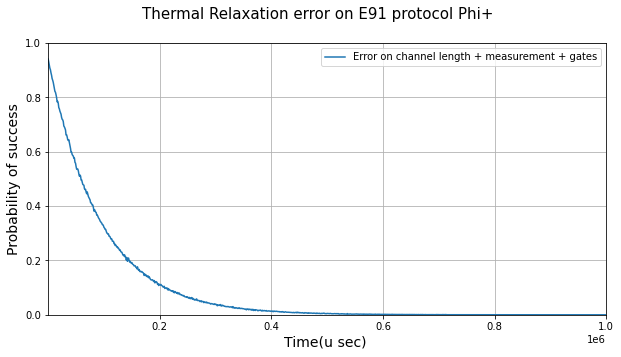

<Figure size 576x360 with 0 Axes>

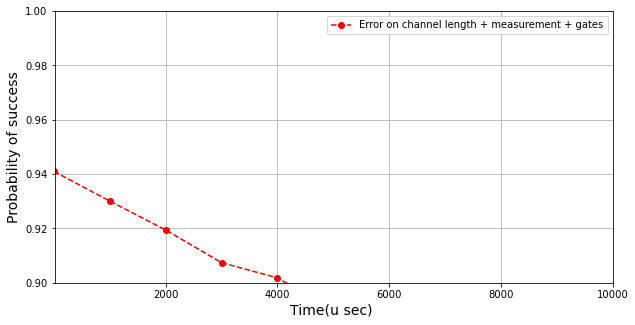

<Figure size 576x360 with 0 Axes>

In [54]:
%config InlineBackend.print_figure_kwargs={'facecolor' : "w"}
import matplotlib.pyplot as plt
from matplotlib.ticker import (AutoMinorLocator, MultipleLocator)
fig, ax = plt.subplots(figsize=(10, 5))
fig.suptitle('Thermal Relaxation error on E91 protocol Phi+',fontsize=15)
ax.set_xlim(10, 1000000)
ax.set_ylim(0,1)
plt.ylabel('Probability of success',fontsize=14)
plt.xlabel('Time(u sec) ',fontsize=14)
plt.grid()

fig = plt.figure(figsize=(8,5))
ax.plot(delay,d2,label = "Error on channel length + measurement + gates")
ax.legend()

#################################################################################

%config InlineBackend.print_figure_kwargs={'facecolor' : "w"}
import matplotlib.pyplot as plt
from matplotlib.ticker import (AutoMinorLocator, MultipleLocator)
fig, ax = plt.subplots(figsize=(10, 5))
#fig.suptitle('Thermal Relaxation error on E91 protocol',fontsize=15)
ax.set_xlim(10, 10000)
ax.set_ylim(0.9,1)
plt.ylabel('Probability of success',fontsize=14)
plt.xlabel('Time(u sec) ',fontsize=14)
plt.grid()
fig = plt.figure(figsize=(8,5))

ax.plot(delay,d2,'ro--',label = "Error on channel length + measurement + gates")
ax.legend()

# Delay and Gate

In [37]:
import matplotlib.pyplot as plt

listofSuccess_DG=[]
for x in range(20): #loop for 20 times average
    delay = np.arange(0,1001000,1000)
    channel = '1'
    apply_error = {"delay":True, "measure": False, "gate": True}
    success = []

    # need to run in multiple loops to get a smoother curve
    for d in range(len(delay)):
        prob = run(channel,int(delay[d]),apply_error)
        success.append(prob)
    #print(success) Enable it to see the reading
    listofSuccess_DG.append(success)
    

In [38]:
from statistics import mean
a= listofSuccess_DG
print(*map(mean, zip(*a)))

0.9949 0.98435 0.9774499999999999 0.96785 0.9557 0.94765 0.9413 0.92815 0.91815 0.9139 0.911 0.90095 0.8893 0.8852 0.8769 0.87245 0.86705 0.85755 0.85185 0.84785 0.84255 0.8405 0.83355 0.8272999999999999 0.8218 0.81585 0.8140499999999999 0.81175 0.80605 0.8001 0.80335 0.79895 0.79105 0.7905500000000001 0.7896500000000001 0.777 0.7827500000000001 0.7725 0.7762 0.77535 0.7769 0.77205 0.76775 0.76795 0.7703 0.76125 0.76175 0.75675 0.75805 0.7579 0.75895 0.7534 0.75495 0.7552 0.75085 0.7548 0.7553 0.7527 0.75215 0.75055 0.7471 0.7477 0.7493 0.74845 0.74965 0.74875 0.7481 0.7522 0.7536 0.75335 0.7484 0.74845 0.7509 0.75745 0.7512 0.7561 0.75595 0.75625 0.756 0.7588 0.7599 0.75035 0.7567 0.75385 0.75495 0.7606 0.75925 0.7679 0.7645500000000001 0.76225 0.758 0.76175 0.7667 0.77005 0.7756500000000001 0.7676000000000001 0.7718 0.7706000000000001 0.7728 0.77175 0.77125 0.77545 0.77695 0.78145 0.78045 0.7801 0.78195 0.7824 0.7813 0.7889 0.7888000000000001 0.7875000000000001 0.7893 0.7836500000000

In [39]:
e= [0.9949,0.98435,0.9774499999999999,0.96785,0.9557,0.94765,0.9413,0.92815,0.91815,0.9139,0.911,0.90095,0.8893,0.8852,0.8769,0.87245,0.86705,0.85755,0.85185,0.84785,0.84255,0.8405,0.83355,0.8272999999999999,0.8218,0.81585,0.8140499999999999,0.81175,0.80605,0.8001,0.80335,0.79895,0.79105,0.7905500000000001,0.7896500000000001,0.777,0.7827500000000001,0.7725,0.7762,0.77535,0.7769,0.77205,0.76775,0.76795,0.7703,0.76125,0.76175,0.75675,0.75805,0.7579,0.75895,0.7534,0.75495,0.7552,0.75085,0.7548,0.7553,0.7527,0.75215,0.75055,0.7471,0.7477,0.7493,0.74845,0.74965,0.74875,0.7481,0.7522,0.7536,0.75335,0.7484,0.74845,0.7509,0.75745,0.7512,0.7561,0.75595,0.75625,0.756,0.7588,0.7599,0.75035,0.7567,0.75385,0.75495,0.7606,0.75925,0.7679,0.7645500000000001,0.76225,0.758,0.76175,0.7667,0.77005,0.7756500000000001,0.7676000000000001,0.7718,0.7706000000000001,0.7728,0.77175,0.77125,0.77545,0.77695,0.78145,0.78045,0.7801,0.78195,0.7824,0.7813,0.7889,0.7888000000000001,0.7875000000000001,0.7893,0.7836500000000001,0.78905,0.7884,0.79965,0.7981,0.79835,0.7966500000000001,0.80105,0.804,0.80525,0.80855,0.8063,0.8097,0.8101,0.8142,0.809,0.8142,0.81175,0.812,0.81435,0.8147,0.817,0.81775,0.8241499999999999,0.8180999999999999,0.8277,0.82205,0.82535,0.83075,0.8323999999999999,0.83415,0.8369,0.8343499999999999,0.8334,0.8366,0.8322999999999999,0.83265,0.8393499999999999,0.8456,0.8437,0.8457,0.8482,0.84725,0.8469,0.8527,0.84655,0.84915,0.84375,0.8527,0.8548,0.8602,0.85935,0.8594999999999999,0.86395,0.86105,0.86275,0.86475,0.8658,0.8654,0.86735,0.86465,0.8681,0.87205,0.87195,0.87465,0.87315,0.8764,0.8777,0.87455,0.8758,0.87835,0.88165,0.88205,0.88675,0.8837,0.8835500000000001,0.8828,0.88395,0.8897,0.89145,0.89215,0.8924,0.8909,0.8937,0.8948,0.8969,0.8971,0.8958,0.896,0.8982,0.9034,0.896,0.90325,0.9046000000000001,0.90425,0.9052,0.9057000000000001,0.90235,0.90925,0.9107500000000001,0.9095,0.90805,0.9136500000000001,0.91025,0.9109,0.9146000000000001,0.9103,0.91325,0.91225,0.9147500000000001,0.9172,0.9195500000000001,0.9185000000000001,0.9188500000000001,0.9173,0.9239,0.9191,0.9221,0.9226000000000001,0.9208500000000001,0.9239,0.92555,0.92695,0.93005,0.92525,0.9313,0.92805,0.9295,0.9307500000000001,0.93055,0.93245,0.936,0.9375,0.93315,0.9324,0.94025,0.9339500000000001,0.9347,0.93425,0.93715,0.93745,0.93975,0.9403,0.9416,0.94085,0.9419,0.94345,0.94285,0.9419,0.94635,0.9441499999999999,0.944,0.9462499999999999,0.9444,0.9481499999999999,0.9465,0.9473999999999999,0.9471499999999999,0.94755,0.9481999999999999,0.9494499999999999,0.9514499999999999,0.95305,0.9506,0.9492999999999999,0.9518,0.9527,0.95295,0.9551499999999999,0.9541,0.9538,0.95275,0.95705,0.9535,0.9578,0.957,0.9552999999999999,0.95565,0.9577,0.95765,0.9597,0.95865,0.9615,0.96105,0.9592499999999999,0.96055,0.96095,0.9613499999999999,0.9623499999999999,0.9624499999999999,0.96195,0.9644999999999999,0.9622499999999999,0.9643999999999999,0.9642499999999999,0.96565,0.96465,0.9658,0.9652499999999999,0.96275,0.96705,0.9677,0.9658,0.9653999999999999,0.9661,0.9682999999999999,0.96915,0.9682999999999999,0.9689,0.9688,0.96925,0.9704999999999999,0.97055,0.9699,0.97015,0.9714499999999999,0.9733999999999999,0.97155,0.9704499999999999,0.9721,0.97355,0.9732,0.9744999999999999,0.9733999999999999,0.9715,0.97475,0.9753999999999999,0.9741,0.9747,0.9744499999999999,0.9758,0.9746,0.97285,0.9744999999999999,0.97775,0.9768,0.97675,0.9778,0.97755,0.9764999999999999,0.9777,0.97625,0.97875,0.9779,0.97975,0.9793,0.97795,0.9798,0.9797,0.98015,0.98265,0.9807,0.98005,0.98165,0.9808,0.9804499999999999,0.98155,0.9818,0.9826,0.9828,0.9822,0.98235,0.9849,0.98195,0.98355,0.9824999999999999,0.9841,0.98375,0.9843999999999999,0.9843999999999999,0.9823999999999999,0.9844999999999999,0.98425,0.9852,0.98485,0.9866,0.9861,0.9835,0.98455,0.98435,0.987,0.98675,0.9842,0.98525,0.98705,0.9864499999999999,0.98575,0.9871,0.9879,0.98785,0.9868,0.98775,0.9872,0.98705,0.9876,0.9878,0.98755,0.9868,0.9879,0.98795,0.988,0.9884,0.9875,0.98735,0.99015,0.98975,0.98925,0.98855,0.9896,0.9873999999999999,0.9889,0.9893,0.9893,0.99,0.9883,0.9895,0.99055,0.9903,0.9896,0.98935,0.9892,0.99065,0.9915,0.99095,0.9914499999999999,0.9915,0.99095,0.99135,0.9919,0.99155,0.9902,0.9916,0.99075,0.9904,0.99175,0.99185,0.9916,0.9914499999999999,0.99235,0.99285,0.99185,0.99325,0.99315,0.9924999999999999,0.9922,0.9922,0.99235,0.9924,0.9932,0.9929,0.99415,0.9926,0.99325,0.9944999999999999,0.9934499999999999,0.9935,0.99395,0.9943,0.994,0.99375,0.99405,0.99405,0.99365,0.99405,0.9941,0.9942,0.99255,0.994,0.9944,0.9938,0.9942,0.9951,0.99335,0.995,0.9952,0.9951,0.9937,0.99375,0.9947,0.99485,0.99385,0.995,0.99535,0.9958,0.99565,0.99455,0.99575,0.9955,0.9955,0.99625,0.99605,0.99515,0.9962,0.99545,0.99535,0.9959,0.9962,0.99615,0.99615,0.99565,0.99555,0.99605,0.99615,0.99675,0.9962,0.9968,0.99625,0.99635,0.99625,0.99655,0.9953,0.9962,0.9971,0.9961,0.9963,0.9961,0.99675,0.99635,0.99635,0.99625,0.9968,0.99695,0.99665,0.9975,0.9968,0.99715,0.99675,0.99715,0.99765,0.9966,0.99705,0.9971,0.9977,0.99745,0.99655,0.9968,0.9977,0.99705,0.9975,0.99725,0.9978,0.99675,0.99685,0.9975,0.99705,0.99745,0.9977,0.99755,0.99725,0.9976,0.9978,0.9981,0.9971,0.99745,0.99775,0.99765,0.99775,0.9979,0.99805,0.99795,0.99795,0.99825,0.99765,0.99795,0.9978,0.99795,0.99795,0.99795,0.9986,0.99755,0.998,0.998,0.9989,0.99805,0.99775,0.99805,0.99815,0.99785,0.9982,0.9982,0.99855,0.9983,0.99855,0.99855,0.9984,0.99795,0.9984,0.9981,0.9984999999999999,0.99795,0.9986,0.9986,0.999,0.9986,0.99845,0.99855,0.9983,0.99865,0.99875,0.9984999999999999,0.99865,0.9986,0.9987,0.9987,0.99875,0.99865,0.99895,0.99875,0.99885,0.9989,0.9992,0.99885,0.99905,0.9989,0.9992,0.99865,0.99875,0.99895,0.99865,0.99925,0.99865,0.9989,0.9989,0.9984999999999999,0.9991,0.99885,0.999,0.99925,0.9991,0.9993,0.999,0.999,0.99925,0.9995,0.99925,0.9992,0.99845,0.9987,0.99875,0.999,0.9992,0.9992,0.9995,0.9994,0.99925,0.99945,0.9987,0.99925,0.99925,0.9993,0.9996,0.9997,0.99925,0.9993,0.9989,0.9994,0.9993,0.9992,0.99945,0.99935,0.999,0.9992,0.9993,0.99935,0.9994,0.9992,0.9995,0.99965,0.999,0.9996,0.99935,0.99955,0.9996,0.9994,0.9993,0.9993,0.9996,0.9995,0.99905,0.9995,0.9995,0.9994,0.99975,0.99945,0.99955,0.99925,0.99935,0.9993,0.99945,0.9993,0.9992,0.9995,0.9992,0.9996,0.99925,0.9993,0.99975,0.99935,0.9995,0.9995,0.9995,0.99955,0.99935,0.9996,0.99955,0.9995,0.9991,0.9995,0.99965,0.99965,0.9996,0.99955,0.9996,0.9996,0.9998,0.99945,0.99945,0.9994,0.9997,0.9994,0.99965,0.9995,0.9998,0.99955,0.9998,0.99965,0.9997,0.99945,0.99945,0.9998,0.99955,0.9996,0.9996,0.9996,0.9997,0.9998,0.99965,0.9996,0.99975,0.9998,0.99945,0.99965,0.9997,0.99965,0.99965,0.99955,0.9995,0.9998,0.99965,0.99975,0.9997,0.9998,0.99955,0.99995,0.9998,0.9997,0.9997,0.9999,0.9998,0.99975,0.99965,0.99965,0.99955,0.99965,0.99975,0.9998,0.99975,0.9998,0.99975,0.9997,0.99985,0.9997,0.9998,0.99985,0.9998,0.99975,0.9999,0.9998,0.99965,0.99975,0.99985,0.9998,0.99975,0.99965,0.99995,0.99985,0.9996,0.9999,0.99975,0.9998,0.9998,0.9998,0.99985,0.99975,0.99985,0.99985,0.9998,0.99985,0.9999,0.99985,0.99985,0.99975,0.9999,0.9998,0.99985,0.9997,0.99975,0.99985,0.99995,0.99985,0.9998,0.99995,0.9999,1.0,0.99975,0.9998,0.99985,0.99975,0.99985,0.9999,0.99995,0.9999,0.99985,0.99985,0.99995,0.9999,0.99995,0.99975,0.9998,0.9999,0.9998,0.99995,0.99985,0.99995,0.9999,0.99985,0.9998,0.99985,1.0,0.99995,1.0,0.99985,1.0,0.99985,0.9999,0.99985,0.9999,0.99995,0.99995,0.9999,1.0,0.99995,0.99985,0.9999,0.99995,0.99995,1.0,0.99995,0.99985,0.99985,0.9999,0.9999,0.99985,0.99985,1.0,0.9999,0.99995,0.9999,0.99995,0.99995,0.99995,0.9999,0.9998,0.99995,0.99995,0.99995,0.9999,1.0,0.9999,1.0,1.0,0.99995,0.99995,1.0,1.0,0.9999,0.9999,0.99985,0.9999,0.9999,0.99995,1.0,0.9999,0.99995,0.99995,0.9999,0.99995,0.99995,0.99995,0.99995,0.99995,1.0,0.99995,1.0,1.0,1.0,0.9999,0.99995,1.0,0.9998,0.99995,0.99995,0.9999,0.9999,0.99995,0.99995,0.99995,0.99995,0.99985,0.99995,0.9999,1.0,1.0,0.9999,0.99995,1.0,0.99995,1.0,0.9999,1.0,1.0,0.99995,1.0,1.0,1.0,0.99995,0.9999,0.99995,1.0,1.0,1.0,0.9999,1.0,0.9999,1.0,1.0,0.99985,0.99995,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.9999,1.0,1.0,1.0,1.0,0.99995,0.99995,0.99995,0.99995,1.0,0.9999,1.0,0.99995,0.99995,0.9999,1.0,1.0,0.99995,1.0,0.99995,1.0,0.99995,1.0,1.0,1.0,1.0,1.0,0.9999,1.0,1.0,1.0,0.99995,1.0]


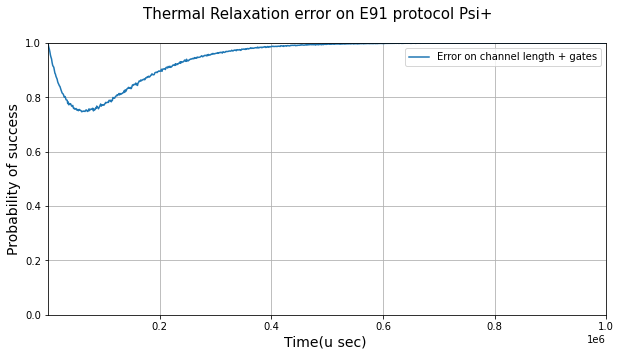

<Figure size 576x360 with 0 Axes>

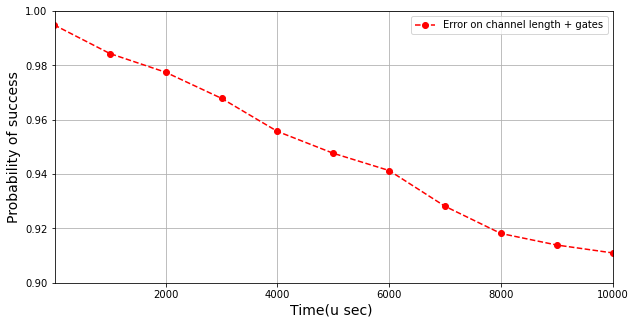

<Figure size 576x360 with 0 Axes>

In [40]:
%config InlineBackend.print_figure_kwargs={'facecolor' : "w"}
import matplotlib.pyplot as plt
from matplotlib.ticker import (AutoMinorLocator, MultipleLocator)
fig, ax = plt.subplots(figsize=(10, 5))
fig.suptitle('Thermal Relaxation error on E91 protocol Psi+',fontsize=15)
ax.set_xlim(10, 1000000)
ax.set_ylim(0,1)
plt.ylabel('Probability of success',fontsize=14)
plt.xlabel('Time(u sec) ',fontsize=14)
plt.grid()

fig = plt.figure(figsize=(8,5))
ax.plot(delay,e,label = "Error on channel length + gates")
ax.legend()

#################################################################################

%config InlineBackend.print_figure_kwargs={'facecolor' : "w"}
import matplotlib.pyplot as plt
from matplotlib.ticker import (AutoMinorLocator, MultipleLocator)
fig, ax = plt.subplots(figsize=(10, 5))
#fig.suptitle('Thermal Relaxation error on E91 protocol',fontsize=15)
ax.set_xlim(10, 10000)
ax.set_ylim(0.9,1)
plt.ylabel('Probability of success',fontsize=14)
plt.xlabel('Time(u sec) ',fontsize=14)
plt.grid()
fig = plt.figure(figsize=(8,5))

ax.plot(delay,e,'ro--',label = "Error on channel length + gates")
ax.legend()

In [45]:
import matplotlib.pyplot as plt

listofSuccess_DG=[]
for x in range(20): #loop for 20 times average
    delay = np.arange(0,1001000,1000)
    channel = '2'
    apply_error = {"delay":True, "measure": False, "gate": True}
    success = []

    # need to run in multiple loops to get a smoother curve
    for d in range(len(delay)):
        prob = run(channel,int(delay[d]),apply_error)
        success.append(prob)
    #print(success) Enable it to see the reading
    listofSuccess_DG.append(success)
    

In [46]:
from statistics import mean
a= listofSuccess_DG
print(*map(mean, zip(*a)))

0.9958 0.9858 0.9733999999999999 0.96495 0.9548 0.94285 0.9318000000000001 0.92345 0.9113 0.8994 0.8924 0.8846 0.87085 0.8678 0.8579 0.84565 0.8403499999999999 0.828 0.81825 0.81285 0.80785 0.7971 0.7919 0.77715 0.7694 0.76495 0.75255 0.74965 0.74175 0.73395 0.7207 0.71485 0.7093499999999999 0.70445 0.6872 0.6865 0.68215 0.66905 0.6634 0.65425 0.6497 0.64735 0.63485 0.6299 0.619 0.6152 0.6051 0.5994499999999999 0.59765 0.58865 0.5896 0.5811999999999999 0.5730999999999999 0.55975 0.5566 0.5531 0.54865 0.5369 0.5331 0.53335 0.5185 0.51425 0.5143 0.5098 0.49935 0.49524999999999997 0.4895 0.48505 0.48009999999999997 0.4754 0.47665 0.46855 0.46225 0.45455 0.45535 0.44925 0.44535 0.4367 0.4308 0.4294 0.418 0.4223 0.411 0.40705 0.4082 0.3997 0.4027 0.392 0.3865 0.3879 0.3781 0.37695 0.37035 0.36719999999999997 0.36765 0.36135 0.3569 0.36125 0.35335 0.3472 0.337 0.3346 0.33455 0.32655 0.32515 0.31955 0.32230000000000003 0.31385 0.3126 0.31685 0.30785 0.3036 0.29714999999999997 0.29975 0.2961 0

In [49]:
e2=[0.9958,0.9858,0.9733999999999999,0.96495,0.9548,0.94285,0.9318000000000001,0.92345,0.9113,0.8994,0.8924,0.8846,0.87085,0.8678,0.8579,0.84565,0.8403499999999999,0.828,0.81825,0.81285,0.80785,0.7971,0.7919,0.77715,0.7694,0.76495,0.75255,0.74965,0.74175,0.73395,0.7207,0.71485,0.7093499999999999,0.70445,0.6872,0.6865,0.68215,0.66905,0.6634,0.65425,0.6497,0.64735,0.63485,0.6299,0.619,0.6152,0.6051,0.5994499999999999,0.59765,0.58865,0.5896,0.5811999999999999,0.5730999999999999,0.55975,0.5566,0.5531,0.54865,0.5369,0.5331,0.53335,0.5185,0.51425,0.5143,0.5098,0.49935,0.49524999999999997,0.4895,0.48505,0.48009999999999997,0.4754,0.47665,0.46855,0.46225,0.45455,0.45535,0.44925,0.44535,0.4367,0.4308,0.4294,0.418,0.4223,0.411,0.40705,0.4082,0.3997,0.4027,0.392,0.3865,0.3879,0.3781,0.37695,0.37035,0.36719999999999997,0.36765,0.36135,0.3569,0.36125,0.35335,0.3472,0.337,0.3346,0.33455,0.32655,0.32515,0.31955,0.32230000000000003,0.31385,0.3126,0.31685,0.30785,0.3036,0.29714999999999997,0.29975,0.2961,0.28905,0.28425,0.2832,0.28525,0.2757,0.2746,0.275,0.26615,0.2646,0.26180000000000003,0.26025,0.2567,0.2509,0.25085,0.2475,0.2433,0.2506,0.2407,0.2382,0.23795,0.2376,0.23005,0.22835,0.2272,0.22345,0.22505,0.2165,0.222,0.2122,0.2137,0.2086,0.2073,0.20895,0.20195,0.20305,0.2027,0.194,0.19715,0.191,0.19625,0.19305,0.1895,0.1882,0.18359999999999999,0.18309999999999998,0.1787,0.1813,0.1755,0.17745,0.17255,0.16795,0.16805,0.16815,0.1647,0.16485,0.16225,0.16035,0.1598,0.1578,0.15705,0.1522,0.1534,0.15135,0.1428,0.14335,0.14825,0.1485,0.1443,0.1393,0.1394,0.13745000000000002,0.13125,0.13355,0.1354,0.1291,0.1256,0.1279,0.129,0.1258,0.12525,0.12190000000000001,0.12175,0.12240000000000001,0.123,0.1157,0.1154,0.11775000000000001,0.1174,0.11095,0.11875,0.10655,0.1081,0.10725,0.10955,0.10575,0.10215,0.10065,0.09805,0.1018,0.1043,0.0983,0.09875,0.09625,0.09695,0.0931,0.09425,0.0953,0.0912,0.09105,0.08889999999999999,0.0899,0.089,0.0868,0.0848,0.0831,0.083,0.0819,0.07985,0.0817,0.0817,0.07805,0.081,0.0801,0.0782,0.0764,0.07585,0.07645,0.0748,0.0753,0.0722,0.0711,0.07035,0.07325,0.06825,0.07225,0.0692,0.06735000000000001,0.07045,0.06695,0.06495,0.06595000000000001,0.0685,0.06575,0.06385,0.0591,0.0615,0.06255,0.06235,0.0589,0.05965,0.06,0.05795,0.0557,0.05865,0.05685,0.05465,0.0537,0.05615,0.0525,0.05175,0.05035,0.053899999999999997,0.0515,0.05115,0.05125,0.04745,0.04765,0.048799999999999996,0.0489,0.0467,0.04775,0.04675,0.04655,0.04695,0.04405,0.0455,0.04775,0.04315,0.047,0.0419,0.04305,0.04105,0.0432,0.0431,0.04025,0.04075,0.0392,0.0389,0.0392,0.03665,0.03565,0.0373,0.0387,0.03565,0.03995,0.0361,0.036699999999999997,0.0356,0.0344,0.0344,0.034,0.03375,0.03485,0.03295,0.03305,0.03315,0.0328,0.03395,0.0308,0.03075,0.03065,0.03035,0.0294,0.0286,0.02895,0.03,0.0293,0.0272,0.0241,0.02655,0.0269,0.02835,0.02495,0.02505,0.02785,0.024,0.0269,0.0263,0.026,0.0246,0.0239,0.0257,0.0248,0.02495,0.0241,0.02335,0.0229,0.0228,0.02325,0.0219,0.0223,0.02265,0.02125,0.0216,0.02055,0.02075,0.0222,0.0221,0.0213,0.02105,0.01825,0.0214,0.0205,0.0176,0.0175,0.02075,0.0179,0.0197,0.01885,0.01935,0.0186,0.0174,0.019,0.019200000000000002,0.017,0.01775,0.01735,0.01795,0.0177,0.01745,0.0184,0.016050000000000002,0.0154,0.0165,0.0144,0.01575,0.0145,0.0153,0.0153,0.014,0.0146,0.015,0.014499999999999999,0.01295,0.01235,0.01425,0.01375,0.01255,0.0128,0.0138,0.0116,0.0141,0.01365,0.0127,0.0134,0.011049999999999999,0.0113,0.01285,0.0131,0.01165,0.0123,0.01185,0.01155,0.0106,0.0115,0.01105,0.0114,0.01,0.01015,0.0114,0.0102,0.011,0.0116,0.010199999999999999,0.0106,0.0095,0.00955,0.0097,0.009,0.00925,0.0095,0.009,0.00875,0.00885,0.00935,0.0095,0.0085,0.00825,0.0102,0.00995,0.00845,0.00815,0.008749999999999999,0.00815,0.00795,0.00855,0.00855,0.0075,0.0078,0.008,0.0074,0.00775,0.0066,0.00675,0.00845,0.00745,0.0065,0.0073,0.00635,0.0073,0.0070999999999999995,0.00715,0.0071,0.00635,0.0063,0.00625,0.0076,0.00635,0.0055,0.00675,0.0063,0.0074,0.00645,0.0067,0.0059,0.0061,0.0055,0.0054,0.00595,0.0054,0.0051,0.00495,0.0054,0.0054,0.00645,0.00555,0.0059,0.0049,0.0055,0.0042,0.0054,0.00535,0.0043,0.00455,0.0044,0.0041,0.00385,0.0046500000000000005,0.00375,0.0048000000000000004,0.00475,0.00425,0.0043,0.0048000000000000004,0.0046,0.00415,0.00405,0.00375,0.00425,0.00355,0.0036,0.0035,0.0036,0.00375,0.00365,0.00425,0.00295,0.00345,0.00375,0.0042,0.00435,0.00335,0.0033,0.0029000000000000002,0.0038,0.00265,0.00285,0.00305,0.0032500000000000003,0.0037,0.00365,0.00295,0.00365,0.00345,0.003,0.00305,0.00385,0.00295,0.0032500000000000003,0.00305,0.00285,0.00315,0.00265,0.0026,0.0028,0.0021,0.0029000000000000002,0.0029000000000000002,0.0022,0.00205,0.0035,0.0026,0.00275,0.00265,0.00255,0.00285,0.002,0.0022,0.0029000000000000002,0.00225,0.0027,0.00275,0.0019500000000000001,0.0027,0.00205,0.0022,0.0025,0.0022,0.002,0.00235,0.002,0.00185,0.0021,0.0024000000000000002,0.0016,0.00185,0.0017000000000000001,0.00205,0.002,0.00215,0.0018,0.0019,0.0019,0.0021,0.0025,0.00185,0.00185,0.0017000000000000001,0.0014,0.0019500000000000001,0.00175,0.00155,0.0016,0.0014500000000000001,0.0016,0.002,0.0011,0.0015,0.00095,0.0014,0.00165,0.00155,0.00105,0.00155,0.00135,0.00115,0.00105,0.0014500000000000001,0.0019500000000000001,0.0014500000000000001,0.0013,0.0014,0.00155,0.00125,0.00105,0.00105,0.0011,0.00115,0.00105,0.00155,0.0015,0.00115,0.00125,0.00105,0.0013,0.00125,0.00065,0.00125,0.00075,0.0011,0.00115,0.00115,0.0011,0.0014500000000000001,0.0011,0.0011,0.001,0.0008500000000000001,0.00075,0.0012000000000000001,0.0008500000000000001,0.00105,0.00095,0.00105,0.00055,0.00105,0.001,0.00125,0.00105,0.0013,0.0009,0.0008,0.0008,0.0006000000000000001,0.0007,0.0011,0.00095,0.00105,0.00065,0.0008,0.0008,0.00075,0.00065,0.00065,0.0005,0.0014,0.0007,0.0007,0.0007,0.00075,0.0009,0.0008500000000000001,0.00075,0.00065,0.00065,0.00055,0.0005,0.00035,0.0007,0.00065,0.0005,0.00045,0.00065,0.0005,0.0006000000000000001,0.0008,0.0005,0.00045,0.00065,0.00055,0.00065,0.00025,0.0006000000000000001,0.00055,0.0005,0.0007,0.0005,0.0007,0.0005,0.0006000000000000001,0.00055,0.00075,0.00045,0.0007,0.00015000000000000001,0.0005,0.00055,0.0002,0.00045,0.0005,0.00045,0.0005,0.00025,0.00065,0.0002,0.0007,0.00055,0.00030000000000000003,0.00045,0.00055,0.0005,0.0005,0.00055,0.0004,0.00035,0.0004,0.0002,0.00045,0.0002,0.0004,0.0002,0.0005,0.0007,0.00025,0.0006000000000000001,0.0004,0.0002,0.00045,0.0004,0.0005,0.0004,0.00025,0.0002,0.00035,0.0006000000000000001,0.00045,0.0001,0.0001,0.0004,0.00055,0.00035,0.00030000000000000003,0.0006000000000000001,0.00030000000000000003,0.0001,0.00025,0.0002,0.0004,0.0001,0.00025,0.0004,0.00035,0.00030000000000000003,0.00030000000000000003,0.00030000000000000003,0.0001,0.00015000000000000001,0.0002,0.00025,0.0002,0.0004,0.00015000000000000001,0.00030000000000000003,0.0001,0.00015000000000000001,0.00015000000000000001,0.00030000000000000003,0.00015000000000000001,0.00030000000000000003,0.0001,0.0001,0.00015000000000000001,0.0002,0.00025,0.00025,0.0001,0.0002,0.00055,0.00045,0.00015000000000000001,0.00025,0.0002,0.00035,0.00015000000000000001,0.0001,0.0001,0.0002,0.00015000000000000001,5e-05,0.00025,0.00030000000000000003,0.00030000000000000003,0.0001,0.00015000000000000001,0.0001,0.0,0.0001,0.00030000000000000003,0.00025,0.00030000000000000003,0.00015000000000000001,0.0002,0.0001,0.0002,0.00035,5e-05,0.0001,0.00025,0.00030000000000000003,0.00015000000000000001,5e-05,5e-05,0.0002,0.00015000000000000001,0.00025,0.0002,0.00015000000000000001,0.0001,0.0001,0.00055,0.0001,0.0,5e-05,0.00015000000000000001,5e-05,0.0,5e-05,0.00015000000000000001,5e-05,0.00015000000000000001,0.00015000000000000001,0.00015000000000000001,5e-05,0.0001,0.00015000000000000001,0.0001,5e-05,0.00015000000000000001,5e-05,0.0002,0.00015000000000000001,0.0002,0.00025,0.0,5e-05,5e-05,0.0,0.00030000000000000003,0.0001,0.00015000000000000001,0.0,5e-05,5e-05,0.0001,0.0002,0.0,5e-05,0.00015000000000000001,5e-05,0.0,5e-05,0.00025,0.0,5e-05,0.0002,0.0001,5e-05,0.00015000000000000001,0.0001,5e-05,5e-05,0.00015000000000000001,0.0002,5e-05,0.00015000000000000001,5e-05,0.00015000000000000001,0.0,5e-05,0.0,0.0,0.0001,0.0001,5e-05,5e-05,0.0,0.0001,0.0001,0.0002,5e-05,0.00015000000000000001,0.0002,0.00015000000000000001,5e-05,5e-05,0.0,5e-05,0.0001,5e-05,5e-05,0.0,0.0,0.00015000000000000001,0.0001,5e-05,5e-05,0.0001,5e-05,0.0,5e-05,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00015000000000000001,5e-05,5e-05,0.0001,5e-05,0.0,0.0001,5e-05,0.0,0.0,0.0001,0.0,0.0,0.0,0.0,0.0001,5e-05,0.0,0.00015000000000000001,5e-05,0.0,5e-05,0.0,5e-05,0.0001,0.0,5e-05,0.0,0.0,0.0,5e-05,5e-05,0.0,0.0001,5e-05,0.0,0.0,0.0001,0.0,0.0001,0.0,5e-05,0.0,5e-05,5e-05,5e-05,0.0,0.0,0.0001,5e-05,0.0,0.0,0.0,0.0,0.0,0.0,5e-05,0.0,5e-05,0.0,0.0,0.0,5e-05,5e-05,5e-05,0.0,5e-05,0.0]


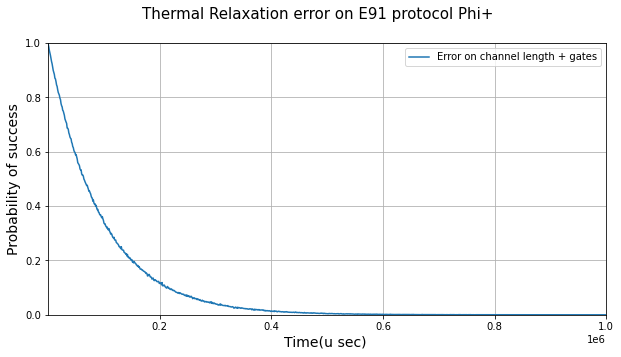

<Figure size 576x360 with 0 Axes>

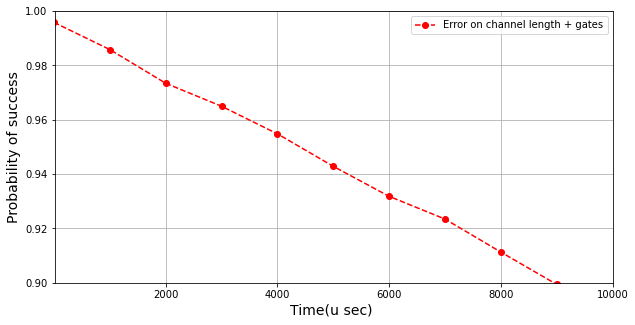

<Figure size 576x360 with 0 Axes>

In [50]:
%config InlineBackend.print_figure_kwargs={'facecolor' : "w"}
import matplotlib.pyplot as plt
from matplotlib.ticker import (AutoMinorLocator, MultipleLocator)
fig, ax = plt.subplots(figsize=(10, 5))
fig.suptitle('Thermal Relaxation error on E91 protocol Phi+',fontsize=15)
ax.set_xlim(10, 1000000)
ax.set_ylim(0,1)
plt.ylabel('Probability of success',fontsize=14)
plt.xlabel('Time(u sec) ',fontsize=14)
plt.grid()

fig = plt.figure(figsize=(8,5))
ax.plot(delay,e2,label = "Error on channel length + gates")
ax.legend()

#################################################################################

%config InlineBackend.print_figure_kwargs={'facecolor' : "w"}
import matplotlib.pyplot as plt
from matplotlib.ticker import (AutoMinorLocator, MultipleLocator)
fig, ax = plt.subplots(figsize=(10, 5))
#fig.suptitle('Thermal Relaxation error on E91 protocol',fontsize=15)
ax.set_xlim(10, 10000)
ax.set_ylim(0.9,1)
plt.ylabel('Probability of success',fontsize=14)
plt.xlabel('Time(u sec) ',fontsize=14)
plt.grid()
fig = plt.figure(figsize=(8,5))

ax.plot(delay,e2,'ro--',label = "Error on channel length + gates")
ax.legend()

# Graph Compairing

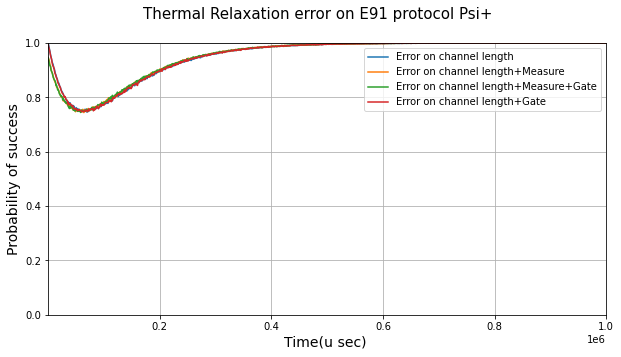

<Figure size 576x360 with 0 Axes>

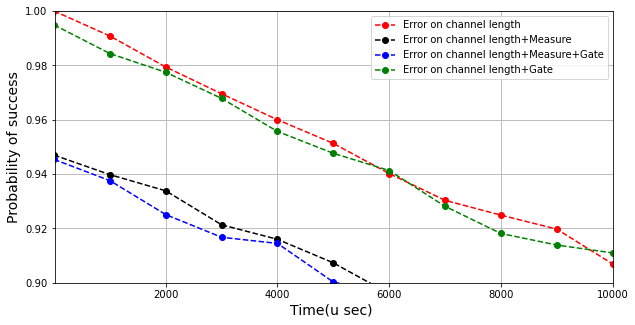

<Figure size 576x360 with 0 Axes>

In [65]:
x1=b
x2=c
x3=d
x4=e
%config InlineBackend.print_figure_kwargs={'facecolor' : "w"}
import matplotlib.pyplot as plt
from matplotlib.ticker import (AutoMinorLocator, MultipleLocator)
fig, ax = plt.subplots(figsize=(10, 5))
fig.suptitle('Thermal Relaxation error on E91 protocol Psi+',fontsize=15)
ax.set_xlim(10, 1000000)
ax.set_ylim(0,1)
plt.ylabel('Probability of success',fontsize=14)
plt.xlabel('Time(u sec) ',fontsize=14)
plt.grid()

fig = plt.figure(figsize=(8,5))
ax.plot(delay,x1,label = "Error on channel length")
ax.plot(delay,x2,label = "Error on channel length+Measure")
ax.plot(delay,x3,label = "Error on channel length+Measure+Gate")
ax.plot(delay,x4,label = "Error on channel length+Gate")
ax.legend()

#################################################################################

%config InlineBackend.print_figure_kwargs={'facecolor' : "w"}
import matplotlib.pyplot as plt
from matplotlib.ticker import (AutoMinorLocator, MultipleLocator)
fig, ax = plt.subplots(figsize=(10, 5))
#fig.suptitle('Thermal Relaxation error on E91 protocol',fontsize=15)
ax.set_xlim(10, 10000)
ax.set_ylim(0.9,1)
plt.ylabel('Probability of success',fontsize=14)
plt.xlabel('Time(u sec) ',fontsize=14)
plt.grid()
fig = plt.figure(figsize=(8,5))

ax.plot(delay,x1,'ro--',label = "Error on channel length")
ax.plot(delay,x2,'ko--',label = "Error on channel length+Measure")
ax.plot(delay,x3,'bo--',label = "Error on channel length+Measure+Gate")
ax.plot(delay,x4,'go--',label = "Error on channel length+Gate")
ax.legend()
#################################################################################




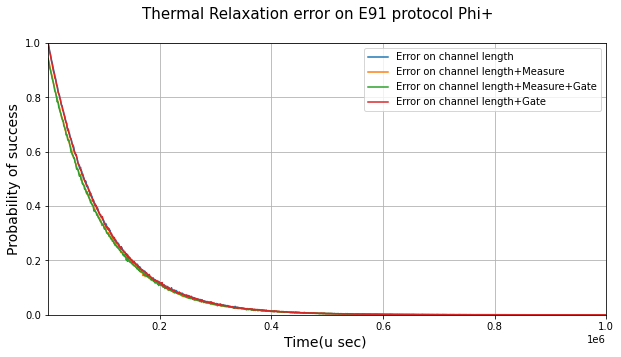

<Figure size 576x360 with 0 Axes>

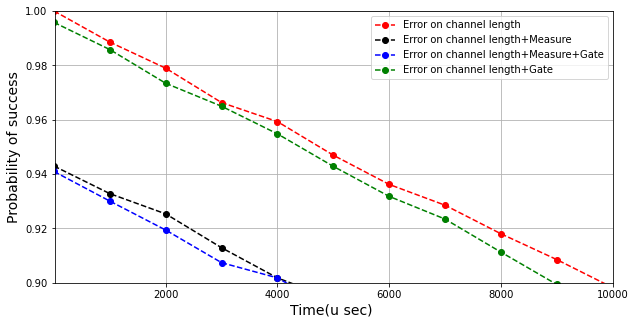

<Figure size 576x360 with 0 Axes>

In [64]:
x1=b2
x2=c2
x3=d2
x4=e2
%config InlineBackend.print_figure_kwargs={'facecolor' : "w"}
import matplotlib.pyplot as plt
from matplotlib.ticker import (AutoMinorLocator, MultipleLocator)
fig, ax = plt.subplots(figsize=(10, 5))
fig.suptitle('Thermal Relaxation error on E91 protocol Phi+',fontsize=15)
ax.set_xlim(10, 1000000)
ax.set_ylim(0,1)
plt.ylabel('Probability of success',fontsize=14)
plt.xlabel('Time(u sec) ',fontsize=14)
plt.grid()

fig = plt.figure(figsize=(8,5))
ax.plot(delay,x1,label = "Error on channel length")
ax.plot(delay,x2,label = "Error on channel length+Measure")
ax.plot(delay,x3,label = "Error on channel length+Measure+Gate")
ax.plot(delay,x4,label = "Error on channel length+Gate")
ax.legend()

#################################################################################

%config InlineBackend.print_figure_kwargs={'facecolor' : "w"}
import matplotlib.pyplot as plt
from matplotlib.ticker import (AutoMinorLocator, MultipleLocator)
fig, ax = plt.subplots(figsize=(10, 5))
#fig.suptitle('Thermal Relaxation error on E91 protocol',fontsize=15)
ax.set_xlim(10, 10000)
ax.set_ylim(0.9,1)
plt.ylabel('Probability of success',fontsize=14)
plt.xlabel('Time(u sec) ',fontsize=14)
plt.grid()
fig = plt.figure(figsize=(8,5))

ax.plot(delay,x1,'ro--',label = "Error on channel length")
ax.plot(delay,x2,'ko--',label = "Error on channel length+Measure")
ax.plot(delay,x3,'bo--',label = "Error on channel length+Measure+Gate")
ax.plot(delay,x4,'go--',label = "Error on channel length+Gate")
ax.legend()
#################################################################################

